# Comparing Supervised and Semi-Supervised Learning for Satellite Image Classification: Insights from High Confidence Pseudo-Labeling and FixMatch

# 1 Import Libraries

In [1]:
# Numerical & Data Processing
import numpy as np  # numerical operations
import pandas as pd  # data handling and manipulation

# System & Utilities
import os  # file and directory operations
import random  # generating random values
from tensorflow.keras import backend as K  # backend operations for custom training behavior
import gc  # garbage collection to free up memory
import shutil  # high-level file operations (e.g., copying, removal)
import time  # time tracking and performance measurement

# Machine Learning - TensorFlow & Keras
import tensorflow as tf  # deep learning framework
from tensorflow.keras import layers, models  # building neural network layers and models
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # image augmentation
from tensorflow.keras.callbacks import EarlyStopping  # stop training when validation performance stops improving
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0  # pretrained MobileNetV2 & EfficientNetB0 architectures
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout  # common layers used in custom heads
from tensorflow.keras.models import Model  # Model API for defining custom architectures
from tensorflow.keras.applications.efficientnet import preprocess_input  # preprocess images for EfficientNet
from tensorflow.keras.models import load_model  # load saved Keras models

# Data Balancing
from sklearn.utils.class_weight import compute_class_weight  # handle class imbalance

# Visualization & Reporting
import matplotlib.pyplot as plt  # plotting and visualizing data
from sklearn.metrics import classification_report  # generate performance report (precision, recall, F1)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # evaluation metrics


# 2 Environment Setup & Reproducibility

In [2]:
# Ensure GPU is available and configured
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to optimize GPU usage
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Using GPU: {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available, using CPU.")

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Define a random seed to enhance reproducability
def set_seeds(seed):
    # Set environment variable for consistent hashing
    os.environ['PYTHONHASHSEED'] = str(seed)

    # Set seed for NumPy, Python's random module, and TensorFlow
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

seed = 54321

# Initialize seeds 
set_seeds(seed)

In [4]:
# Function to fully delete a model and free up memory (important for RTX 3060 with 6GB VRAM)
def clear_model_memory(model):
    # Delete the model object from memory
    del model

    # Clear Keras backend session (frees resources)
    K.clear_session()

    # Trigger garbage collection to free unused memory
    gc.collect()


# Function to clear GPU memory used by TensorFlow/Keras (important for RTX 3060 with 6GB VRAM)
def clear_gpu_memory():
    try:
        # Clear Keras backend session to release resources
        K.clear_session()

        # Run garbage collection to clean up unused memory
        gc.collect()

        # Reset GPU memory stats (only works if supported)
        tf.config.experimental.reset_memory_stats('GPU:0')
    except Exception:
        pass  # Silently ignore if reset_memory_stats is unavailable

    try:
        # Clear Keras backend session again (fallback)
        tf.keras.backend.clear_session()

        # Reset default graph for TF1 compatibility (if applicable)
        tf.compat.v1.reset_default_graph()
    except Exception:
        pass  # Silently ignore if not supported


In [5]:
# Clearing the memory just in case
clear_gpu_memory()

<div style="background-color:#ffcccc; padding:10px; border-left:5px solid red;">
    <b>Note:</b> While these measures significantly enhance reproducibility, results may still vary slightly across runs due to inherent non-determinism in GPU operations (e.g., parallel execution, atomic operations, low-level kernel behavior).
</div>


# 3 Running Models

## 3.1 Data Configuration and Parameters
For defining paths, batch size, input sizes, and number of epochs.

In [6]:
# Defining training and testing file directories for the images
base_dir = "SplitDataset\\" 
train_dir =  'SplitDataset/labeled'
test_dir = 'SplitDataset/test'
unlabeled_initial_dir = 'SplitDataset/unlabeled_initial'
unlabeled_dir = 'SplitDataset/unlabeled_flat'

In [7]:
# Function to count files in a directory (including subdirectories)
def count_files(directory):
    return sum(len(files) for _, _, files in os.walk(directory))

# Count files in each directory
train_count = count_files(train_dir)
test_count = count_files(test_dir)
unlabeled_count = count_files(unlabeled_initial_dir)

print(f"Train files: {train_count}")
print(f"Test files: {test_count}")
print(f"Unlabeled files: {unlabeled_count}")

Train files: 2160
Test files: 5400
Unlabeled files: 19440


In [8]:
# Try and reduce the unlabelled portion by 50% to account for resource limitation.

# Step 1: Delete everything inside unlabeled_dir
for filename in os.listdir(unlabeled_dir):
    file_path = os.path.join(unlabeled_dir, filename)
    if os.path.isfile(file_path) or os.path.islink(file_path):
        os.unlink(file_path)
    elif os.path.isdir(file_path):
        shutil.rmtree(file_path)

# Step 2: Get list of all files in unlabeled_initial_dir
all_files = [f for f in os.listdir(unlabeled_initial_dir) if os.path.isfile(os.path.join(unlabeled_initial_dir, f))]

# Step 3: Randomly select
random.seed(seed)  # for reproducibility
selected_files = random.sample(all_files, len(all_files) // 2)

# Step 4: Copy selected files to unlabeled_dir
for file_name in selected_files:
    src = os.path.join(unlabeled_initial_dir, file_name)
    dst = os.path.join(unlabeled_dir, file_name)
    shutil.copy2(src, dst)

print(f"Copied {len(selected_files)} files to '{unlabeled_dir}'")

Copied 9720 files to 'SplitDataset/unlabeled_flat'


In [9]:
# Define training parameters
batch_size = 8  # Number of samples processed in each training batch, low due to limited VRAM (GPU Memory)

# Specify image input dimensions for different model architectures
img_size64 = (64, 64)        # Input resolution for CNN and MobileNet-based models
img_size224 = (224, 224)     # Required input size for EfficientNet-B0 models

# Set input shape (RGB images)
input_shape64 = (img_size64[0], img_size64[1], 3)       # Input shape for models using 64x64 images
input_shape224 = (img_size224[0], img_size224[1], 3)    # Input shape for models using 224x224 images

# Set number of output classes
num_classes = 10  # The dataset contains 10 distinct classes

# Set the number of training epochs
epochs = 30  # Total number of complete passes through the training dataset
patience = 5

In [10]:
# Configure the EarlyStopping callback to prevent overfitting
# This callback monitors validation loss during training and stops the process 
# if no improvement is observed for a specified number of epochs.
early_stopping = EarlyStopping(
    monitor='val_loss',         # Metric to monitor
    patience=patience,                 # Number of epochs to wait without improvement before stopping
    restore_best_weights=True  # Restores model weights from the epoch with the best monitored metric
)

In [11]:
# Define a function to visually display model predictions on a sample of test images
def display_predictions(model, test_generator, num_examples=5):
    # Retrieve a single batch of images and corresponding true labels from the test generator
    x_test, y_true = test_generator[2]  # Accessing batch index 3 as an example
    y_true = np.argmax(y_true, axis=1)  # Convert one-hot encoded labels to class indices
    
    # Generate model predictions and convert predicted probabilities to class indices
    y_pred = np.argmax(model.predict(x_test), axis=1)
    
    # Retrieve class names from the test generator
    class_names = list(test_generator.class_indices.keys())
    
    # Display the selected number of images with their predicted and true labels
    plt.figure(figsize=(15, 5))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(x_test[i])            # Display the image
        plt.axis('off')                  # Hide axis for clarity
        
        true_label = class_names[y_true[i]]
        pred_label = class_names[y_pred[i]]
        is_correct = true_label == pred_label
        
        # Set the title with actual and predicted labels, and color based on correctness
        plt.title(
            f"True: {true_label}\nPred: {pred_label}\nCorrect: {is_correct}",
            color='green' if is_correct else 'red'
        )
    
    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()


def normalize_for_display(img):
    """Normalize float32 RGB image to [0,1] range for imshow()."""
    return np.clip(img / 255.0, 0, 1)

def display_predictions_effi(model, test_generator, num_examples=5):
    # Retrieve a single batch of images and corresponding true labels from the test generator
    x_test, y_true = test_generator[2]  # Accessing batch index 2 as an example
    y_true = np.argmax(y_true, axis=1)  # Convert one-hot encoded labels to class indices

    # Generate model predictions and convert predicted probabilities to class indices
    y_pred = np.argmax(model.predict(x_test), axis=1)

    # Retrieve class names from the test generator
    class_names = list(test_generator.class_indices.keys())

    # Display the selected number of images with their predicted and true labels
    plt.figure(figsize=(15, 5))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        
        # Normalize image for display
        img_disp = normalize_for_display(x_test[i])
        plt.imshow(img_disp)
        plt.axis('off')
        
        true_label = class_names[y_true[i]]
        pred_label = class_names[y_pred[i]]
        is_correct = true_label == pred_label

        # Title with actual/predicted label and color-coded correctness
        plt.title(
            f"True: {true_label}\nPred: {pred_label}\nCorrect: {is_correct}",
            color='green' if is_correct else 'red'
        )

    plt.tight_layout()
    plt.show()


In [12]:
# Define a function to create a baseline simple Convolutional Neural Network (CNN) model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()

    # First convolutional block: Conv -> ReLU -> MaxPooling
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second convolutional block
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Third convolutional block
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the feature maps into a 1D feature vector
    model.add(layers.Flatten())

    # Fully connected (dense) layer with ReLU activation
    model.add(layers.Dense(128, activation='relu'))

    # Output layer with softmax activation for multi-class classification
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

## 3.2 Data Preparation and Generators
For preparing training and testing datasets, data augmentation, and loading data for different input sizes (e.g., 64×64 for CNN/MobileNet, 224×224 for EfficientNet).

### 3.2.1 Image Augmentation, Normalization & Data Generation

In [13]:
# ============================================
# Image Data Generators for CNN / MobileNet (64x64)
# ============================================

# Define ImageDataGenerator for training with data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0, 1]
    rotation_range=20,          # Random rotation (±20 degrees)
    width_shift_range=0.2,      # Horizontal shift (max 20%)
    height_shift_range=0.2,     # Vertical shift (max 20%)
    shear_range=0.2,            # Shear transformation
    zoom_range=0.2,             # Random zoom
    horizontal_flip=True,       # Random horizontal flipping
    fill_mode='nearest'         # Fill missing pixels with nearest values
)

# Define ImageDataGenerator for testing with only normalization
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and test data for models requiring 64x64 input (CNN / MobileNet)
train_generator64 = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size64,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=seed
)

test_generator64 = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size64,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# ============================================
# Image Data Generators for EfficientNet (224x224)
# ============================================

# Define ImageDataGenerator for EfficientNet with appropriate preprocessing
train_datagen_eff = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Applies EfficientNet-specific normalization:
                                              # Scales pixel values from [0, 255] to [-1, 1] using:
                                              # x' = (x / 127.5) - 1
                                              # This matches the normalization used during EfficientNet pretraining on ImageNet.
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define ImageDataGenerator for EfficientNet test data (no augmentation)
test_datagen_eff = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Load training and test data for models requiring 224x224 input (EfficientNet)
train_generator224 = train_datagen_eff.flow_from_directory(
    train_dir,
    target_size=img_size224,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed = seed
)

test_generator224 = test_datagen_eff.flow_from_directory(
    test_dir,
    target_size=img_size224,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 2160 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.
Found 2160 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


### 3.2.2 Handling Class Imbalance with Weights
Computing class weights to mitigate imbalance during training for both CNN (64x64) and EfficientNet (224x224) input sizes. Class weights are inverse-frequency values assigned to each class to penalize underrepresented classes during training. This ensures the model doesn't become biased toward majority classes and improves performance on imbalanced datasets.



In [14]:
# Extract class labels from the training data directory structure
class_labels = list(train_generator64.class_indices.keys())

# Compute class weights using sklearn library, to address potential class imbalance in the training set
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator64.classes),
    y=train_generator64.classes
)

# Convert the computed weights to a dictionary format for compatibility with model training
class_weights_dict = dict(enumerate(class_weights))

In [15]:
print(class_weights_dict)

{0: 0.9, 1: 0.9, 2: 0.9, 3: 1.08, 4: 1.08, 5: 1.35, 6: 1.08, 7: 0.9, 8: 1.08, 9: 0.9}


## 3.3 Model Training (Supervised Learning)

### 3.3.1 Baseline CNN: Supervised Learning

In [16]:
# Instantiate the CNN model
model_BCNN = create_cnn_model(input_shape64, num_classes)

# Compile the model with Adam optimizer and categorical cross-entropy loss
model_BCNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model architecture and parameter summary
model_BCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [17]:
# Train the CNN model using the training data and evaluate it on the validation (test) set.
# Class weights are applied to address class imbalance, and early stopping is used to prevent overfitting.
history_BCNN = model_BCNN.fit(
    train_generator64,                                   # Training data generator
    steps_per_epoch=train_generator64.samples // batch_size,  # Number of batches per epoch
    epochs=epochs,                                    # Total number of training epochs
    validation_data=test_generator64,                    # Validation data generator
    validation_steps=test_generator64.samples // batch_size,  # Number of validation batches per epoch
    class_weight=class_weights_dict,                   # Dictionary of class weights to balance training
    callbacks=[early_stopping]                         # Apply early stopping based on validation performance
)

Epoch 1/30
270/270 [==============================] - 11s 25ms/step - loss: 1.9225 - accuracy: 0.2384 - val_loss: 1.6872 - val_accuracy: 0.2920
Epoch 2/30
270/270 [==============================] - 7s 24ms/step - loss: 1.6273 - accuracy: 0.3690 - val_loss: 1.7760 - val_accuracy: 0.3624
Epoch 3/30
270/270 [==============================] - 7s 25ms/step - loss: 1.4692 - accuracy: 0.4319 - val_loss: 1.3325 - val_accuracy: 0.5126
Epoch 4/30
270/270 [==============================] - 7s 25ms/step - loss: 1.3845 - accuracy: 0.4722 - val_loss: 1.1787 - val_accuracy: 0.5613
Epoch 5/30
270/270 [==============================] - 7s 25ms/step - loss: 1.2236 - accuracy: 0.5662 - val_loss: 1.0976 - val_accuracy: 0.6044
Epoch 6/30
270/270 [==============================] - 7s 25ms/step - loss: 1.2046 - accuracy: 0.5806 - val_loss: 1.0805 - val_accuracy: 0.6230
Epoch 7/30
270/270 [==============================] - 7s 26ms/step - loss: 1.1044 - accuracy: 0.5995 - val_loss: 1.3430 - val_accuracy: 0.518

675/675 [==============================] - 4s 5ms/step - loss: 0.6797 - accuracy: 0.7641
Test accuracy: 0.7641


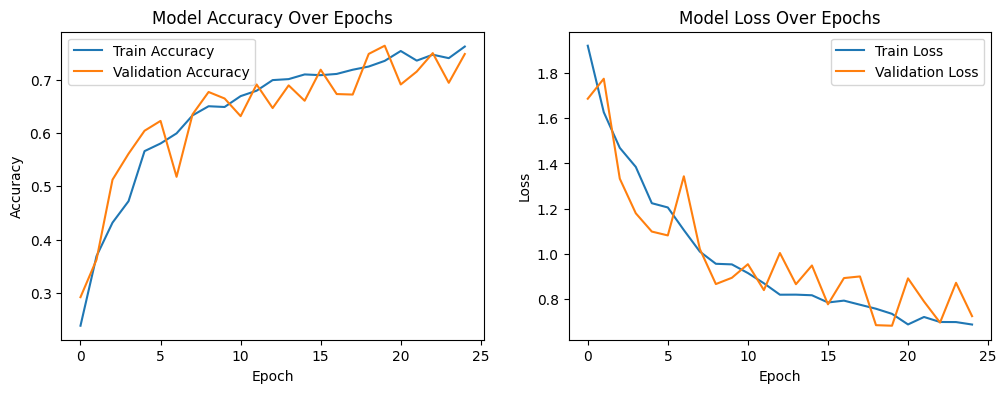

In [18]:
# Evaluate the trained model on the test data and report the final test accuracy
test_loss, test_acc = model_BCNN.evaluate(test_generator64)
print(f'Test accuracy: {test_acc:.4f}')

# Visualize model performance over training epochs

plt.figure(figsize=(12, 4))  # Create a figure with two side-by-side plots

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_BCNN.history['accuracy'], label='Train Accuracy')
plt.plot(history_BCNN.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_BCNN.history['loss'], label='Train Loss')
plt.plot(history_BCNN.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.show()


In [19]:
# Generate predictions and evaluate model performance on the test set

# Ground truth class labels from the test generator
y_true = test_generator64.classes

# Predicted class labels from the model (converted from probabilities to class indices)
y_pred_BCNN = np.argmax(model_BCNN.predict(test_generator64), axis=1)

# Display a detailed classification report including precision, recall, F1-score, and support for each class
print("Classification Report:")
print(classification_report(y_true, y_pred_BCNN, target_names=test_generator64.class_indices.keys()))


675/675 [==============================] - 3s 4ms/step
Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.84      0.83      0.83       600
              Forest       0.94      0.76      0.84       600
HerbaceousVegetation       0.74      0.62      0.68       600
             Highway       0.57      0.42      0.48       500
          Industrial       0.81      0.97      0.88       500
             Pasture       0.64      0.86      0.73       400
       PermanentCrop       0.61      0.62      0.61       500
         Residential       0.89      0.88      0.89       600
               River       0.64      0.77      0.70       500
             SeaLake       0.88      0.91      0.89       600

            accuracy                           0.76      5400
           macro avg       0.76      0.76      0.75      5400
        weighted avg       0.77      0.76      0.76      5400



1/1 [==============================] - 0s 62ms/step


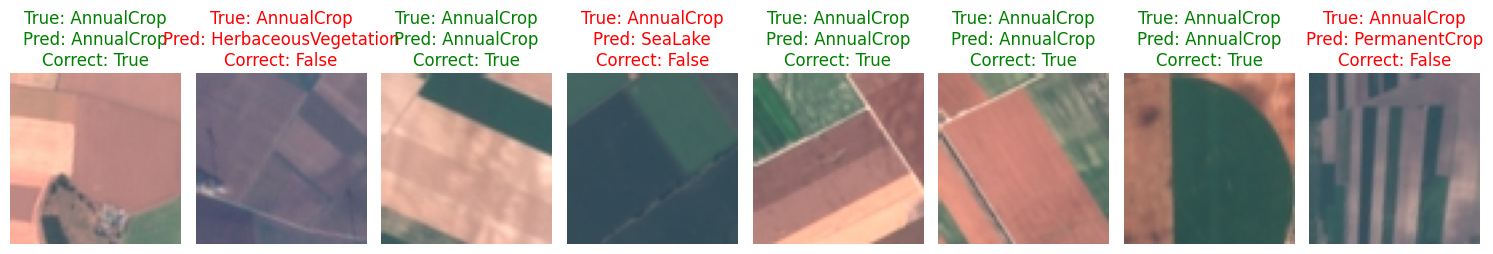

In [20]:
# Call the function to display a selection of model predictions
display_predictions(model_BCNN, test_generator64, num_examples=8)


In [21]:
# Save the model
model_BCNN.save('Initial_Models/eurosat_Baseline_cnn_model.h5')

# Clear the memory
clear_model_memory(model_BCNN)


### 3.3.2 MobileNetV2 Pre-trained on ImageNet: Supervised Learning
In this section, we load the MobileNetV2 model pre-trained on ImageNet as a feature extractor by excluding its top classification layers. The base model’s layers are frozen to retain learned features, and a custom classification head is added for our specific task. This approach allows us to leverage transfer learning without retraining the full network. Fine-tuning or unfreezing the base model is not performed, as it is considered out of scope for this report.

In [22]:
# Load the pre-trained MobileNetV2 model without the top classification layers
base_model_MN = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape64)

# Freeze the base model layers to retain pre-trained features during training
base_model_MN.trainable = False  

# Add custom classification head on top of the base model
x = base_model_MN.output
x = GlobalAveragePooling2D()(x)            # Global Average Pooling to reduce spatial dimensions
x = Dense(128, activation='relu')(x)       # Fully connected layer with ReLU activation
x = Dropout(0.5)(x)                         # Dropout layer for regularization
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer for multi-class classification

# Construct the final model by combining the base and custom layers
model_SMN = Model(inputs=base_model_MN.input, outputs=predictions)

# Compile the model with Adam optimizer and categorical cross-entropy loss
model_SMN.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model architecture
model_SMN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 32, 32, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 32, 32, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 32, 32, 32)   0           ['bn_Conv1[0][0]']               
                                                                                              

In [23]:
# Train the model with early stopping
history_SMN = model_SMN.fit(
    train_generator64,                                   # Training data generator
    steps_per_epoch=train_generator64.samples // batch_size,  # Number of batches per epoch
    epochs=epochs,                                     # Total number of training epochs
    validation_data=test_generator64,                    # Validation data generator
    validation_steps=test_generator64.samples // batch_size,  # Number of validation batches per epoch
    class_weight=class_weights_dict,                   # Dictionary of class weights to balance training
    callbacks=[early_stopping]                         # Apply early stopping based on validation performance
)

Epoch 1/30
270/270 [==============================] - 12s 38ms/step - loss: 1.6572 - accuracy: 0.4620 - val_loss: 1.0250 - val_accuracy: 0.6496
Epoch 2/30
270/270 [==============================] - 9s 34ms/step - loss: 1.2503 - accuracy: 0.5847 - val_loss: 0.8473 - val_accuracy: 0.7163
Epoch 3/30
270/270 [==============================] - 10s 36ms/step - loss: 1.0976 - accuracy: 0.6255 - val_loss: 0.7962 - val_accuracy: 0.7419
Epoch 4/30
270/270 [==============================] - 10s 35ms/step - loss: 1.0363 - accuracy: 0.6532 - val_loss: 0.7715 - val_accuracy: 0.7309
Epoch 5/30
270/270 [==============================] - 9s 34ms/step - loss: 1.0055 - accuracy: 0.6472 - val_loss: 0.7708 - val_accuracy: 0.7369
Epoch 6/30
270/270 [==============================] - 10s 36ms/step - loss: 0.9455 - accuracy: 0.6745 - val_loss: 0.7288 - val_accuracy: 0.7511
Epoch 7/30
270/270 [==============================] - 9s 34ms/step - loss: 0.9255 - accuracy: 0.7037 - val_loss: 0.7096 - val_accuracy: 0.

675/675 [==============================] - 6s 9ms/step - loss: 0.6272 - accuracy: 0.7896
Test accuracy: 0.7896


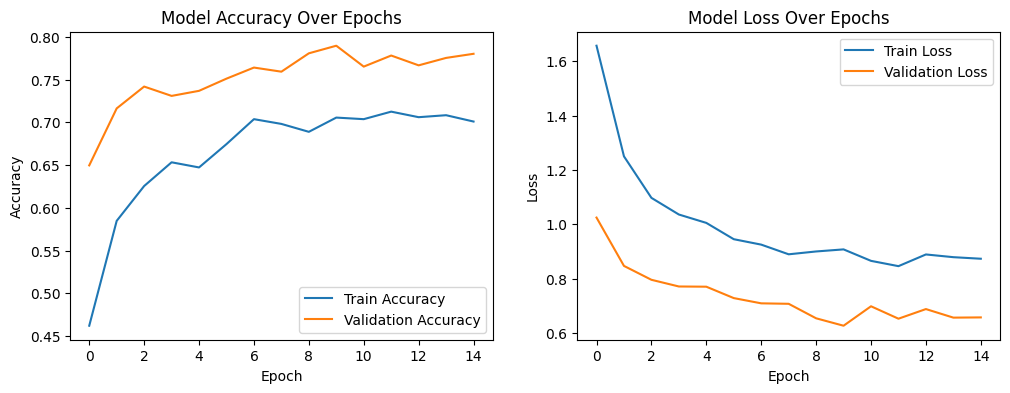

In [24]:
# Evaluate the trained model on the test data and report the final test accuracy
test_loss, test_acc = model_SMN.evaluate(test_generator64)
print(f'Test accuracy: {test_acc:.4f}')

# Visualize model performance over training epochs

plt.figure(figsize=(12, 4))  # Create a figure with two side-by-side plots

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_SMN.history['accuracy'], label='Train Accuracy')
plt.plot(history_SMN.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_SMN.history['loss'], label='Train Loss')
plt.plot(history_SMN.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.show()


In [25]:
# Generate predictions and evaluate model performance on the test set

# Ground truth class labels from the test generator
y_true = test_generator64.classes

# Predicted class labels from the model (converted from probabilities to class indices)
y_pred_SMN = np.argmax(model_SMN.predict(test_generator64), axis=1)

# Display a detailed classification report including precision, recall, F1-score, and support for each class
print("Classification Report:")
print(classification_report(y_true, y_pred_SMN, target_names=test_generator64.class_indices.keys()))


675/675 [==============================] - 6s 8ms/step
Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.91      0.75      0.82       600
              Forest       0.82      0.87      0.84       600
HerbaceousVegetation       0.71      0.74      0.72       600
             Highway       0.69      0.68      0.69       500
          Industrial       0.85      0.89      0.87       500
             Pasture       0.66      0.73      0.69       400
       PermanentCrop       0.68      0.76      0.72       500
         Residential       0.84      0.82      0.83       600
               River       0.73      0.74      0.74       500
             SeaLake       0.98      0.89      0.93       600

            accuracy                           0.79      5400
           macro avg       0.79      0.79      0.79      5400
        weighted avg       0.80      0.79      0.79      5400



1/1 [==============================] - 1s 627ms/step


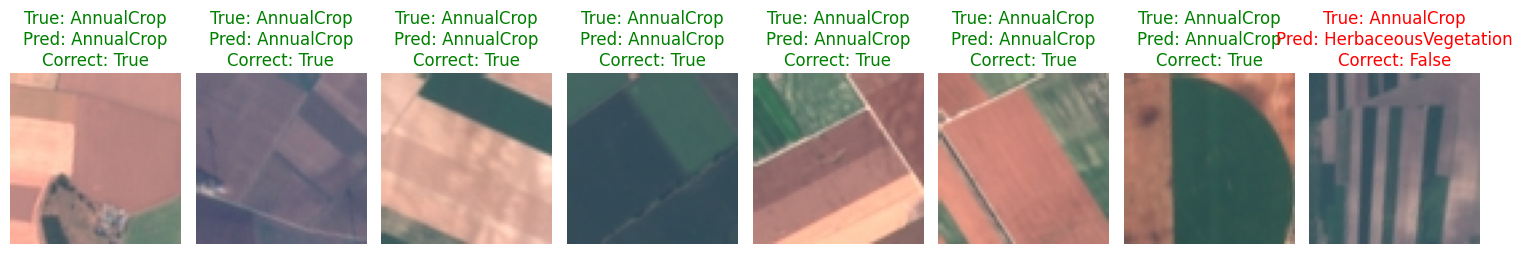

In [26]:
# Call the function to display a selection of model predictions
display_predictions(model_SMN, test_generator64, num_examples=8)


In [27]:
# Save the fine-tuned model
model_SMN.save('Initial_Models/eurosat_mobilenetv2_model.h5')

# Clear the memory
clear_model_memory(model_SMN)

### 3.3.3 EfficientNetB0 Lightweight variant pre-trained on ImageNet: Supervised Learning

In [28]:
# Load the pre-trained EfficientNetB0 model without the top classification layers
base_model_EN = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape224)

# Freeze the base model layers to retain pre-trained features during training
base_model_EN.trainable = False  

# Add custom classification head on top of the base model
x = base_model_EN.output
x = GlobalAveragePooling2D()(x)            # Global Average Pooling to reduce spatial dimensions
x = Dense(128, activation='relu')(x)       # Fully connected layer with ReLU activation
x = Dropout(0.5)(x)                         # Dropout layer for regularization
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer for multi-class classification

# Construct the final model by combining the base and custom layers
model_SEN = Model(inputs=base_model_EN.input, outputs=predictions)

# Compile the model with Adam optimizer and categorical cross-entropy loss
model_SEN.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model architecture
model_SEN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [29]:
# Train the model with early stopping
history_SEN = model_SEN.fit(
    train_generator224,                                   # Training data generator
    steps_per_epoch=train_generator224.samples // batch_size,  # Number of batches per epoch
    epochs=epochs,                                     # Total number of training epochs
    validation_data=test_generator224,                    # Validation data generator
    validation_steps=test_generator224.samples // batch_size,  # Number of validation batches per epoch
    class_weight=class_weights_dict,                   # Dictionary of class weights to balance training
    callbacks=[early_stopping]                         # Apply early stopping based on validation performance
)

Epoch 1/30
270/270 [==============================] - 35s 111ms/step - loss: 1.0427 - accuracy: 0.6542 - val_loss: 0.8023 - val_accuracy: 0.7048
Epoch 2/30
270/270 [==============================] - 29s 107ms/step - loss: 0.6122 - accuracy: 0.7972 - val_loss: 0.6776 - val_accuracy: 0.7470
Epoch 3/30
270/270 [==============================] - 29s 106ms/step - loss: 0.5109 - accuracy: 0.8338 - val_loss: 0.6309 - val_accuracy: 0.7656
Epoch 4/30
270/270 [==============================] - 29s 107ms/step - loss: 0.4899 - accuracy: 0.8375 - val_loss: 0.6112 - val_accuracy: 0.7704
Epoch 5/30
270/270 [==============================] - 29s 108ms/step - loss: 0.4614 - accuracy: 0.8472 - val_loss: 0.5025 - val_accuracy: 0.8087
Epoch 6/30
270/270 [==============================] - 29s 106ms/step - loss: 0.4222 - accuracy: 0.8528 - val_loss: 0.4565 - val_accuracy: 0.8322
Epoch 7/30
270/270 [==============================] - 29s 106ms/step - loss: 0.3987 - accuracy: 0.8685 - val_loss: 0.6153 - val_ac

675/675 [==============================] - 11s 16ms/step - loss: 0.4208 - accuracy: 0.8485
Test accuracy: 0.8485


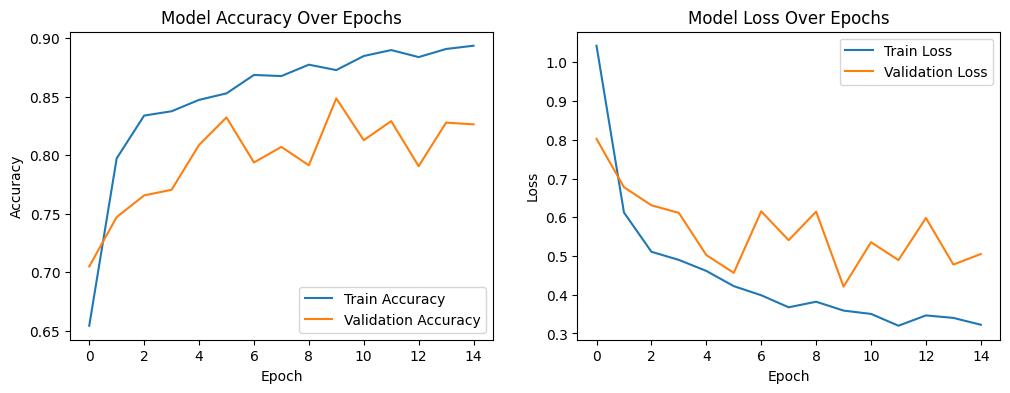

In [30]:
# Evaluate the trained model on the test data and report the final test accuracy
test_loss, test_acc = model_SEN.evaluate(test_generator224)
print(f'Test accuracy: {test_acc:.4f}')

# Visualize model performance over training epochs

plt.figure(figsize=(12, 4))  # Create a figure with two side-by-side plots

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_SEN.history['accuracy'], label='Train Accuracy')
plt.plot(history_SEN.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_SEN.history['loss'], label='Train Loss')
plt.plot(history_SEN.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.show()


In [31]:
# Generate predictions and evaluate model performance on the test set

# Ground truth class labels from the test generator
y_true = test_generator224.classes

# Predicted class labels from the model (converted from probabilities to class indices)
y_pred_SEN = np.argmax(model_SEN.predict(test_generator224), axis=1)

# Display a detailed classification report including precision, recall, F1-score, and support for each class
print("Classification Report:")
print(classification_report(y_true, y_pred_SEN, target_names=test_generator224.class_indices.keys()))


675/675 [==============================] - 11s 15ms/step
Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.91      0.86      0.89       600
              Forest       0.97      0.93      0.95       600
HerbaceousVegetation       0.63      0.94      0.76       600
             Highway       0.76      0.88      0.82       500
          Industrial       0.95      0.79      0.86       500
             Pasture       0.95      0.76      0.84       400
       PermanentCrop       0.79      0.74      0.77       500
         Residential       0.85      0.81      0.83       600
               River       0.87      0.79      0.82       500
             SeaLake       1.00      0.93      0.96       600

            accuracy                           0.85      5400
           macro avg       0.87      0.84      0.85      5400
        weighted avg       0.87      0.85      0.85      5400



In [32]:
images, labels = next(test_generator224)

print("Shape:", images.shape)
print("Dtype:", images.dtype)
print("Min pixel value:", images.min())
print("Max pixel value:", images.max())
print("Mean pixel value:", images.mean())


Shape: (8, 224, 224, 3)
Dtype: float32
Min pixel value: 48.0
Max pixel value: 255.0
Mean pixel value: 130.23627


1/1 [==============================] - 1s 1s/step


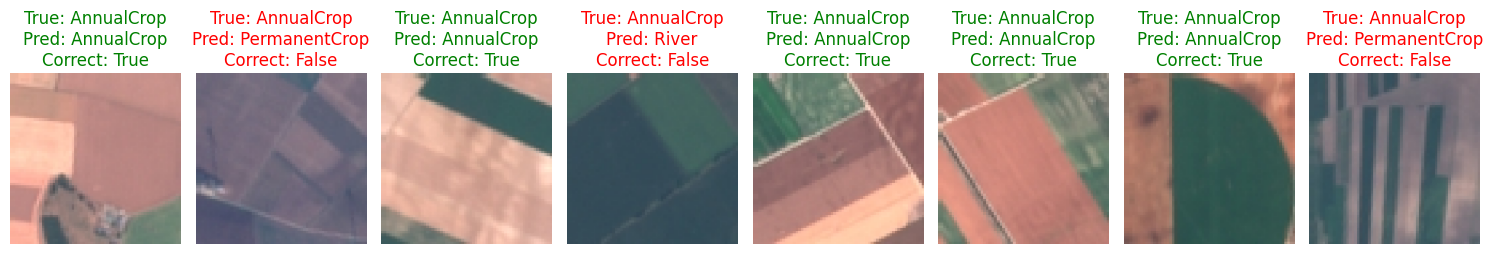

In [33]:
# Call the function to display a selection of model predictions    
display_predictions_effi(model_SEN, test_generator224, num_examples=8)


In [34]:
# Save the fine-tuned modela
tf.saved_model.save(model_SEN, "Initial_Models/efficientnet_model")

# Clear the memory
clear_model_memory(model_SEN)

INFO:tensorflow:Assets written to: Initial_Models/efficientnet_model\assets


INFO:tensorflow:Assets written to: Initial_Models/efficientnet_model\assets


### 3.3.4 Test Overview

In [35]:
# Helper function to calculate all metrics
def get_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_true, y_pred, average='weighted', zero_division=0),
        "F1-Score": f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }

# Compute metrics for each model
results = {
    "Baseline CNN": get_metrics(y_true, y_pred_BCNN),
    "MobileNetV2": get_metrics(y_true, y_pred_SMN),
    "EfficientNetB0": get_metrics(y_true, y_pred_SEN)
}

# Create and display DataFrame
df_results = pd.DataFrame(results).T  # Transpose so models are rows
df_results = df_results.round(6)      # Round to match your format
print(df_results)

                Accuracy  Precision    Recall  F1-Score
Baseline CNN    0.764074   0.767200  0.764074  0.760636
MobileNetV2     0.789630   0.795919  0.789630  0.791289
EfficientNetB0  0.848519   0.866072  0.848519  0.851623


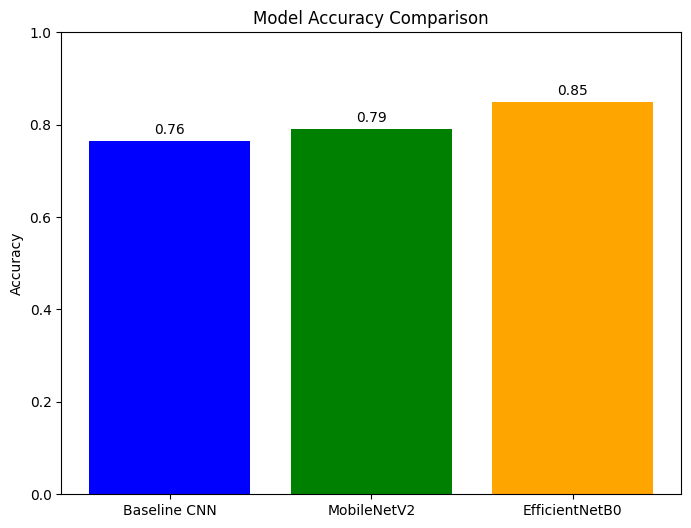

In [36]:
# Model names and accuracies
models_heading = ['Baseline CNN', 'MobileNetV2', 'EfficientNetB0']
accuracies = [results[m]['Accuracy'] for m in models_heading]

# Create a bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(models_heading, accuracies, color=['blue', 'green', 'orange'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add accuracy labels on top of bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f"{acc:.2f}", ha='center', va='bottom', fontsize=10)

plt.show()

In [37]:
clear_gpu_memory()

## 3.4 Model Training (Semi-Supervised Learning - High Confidence Pseudo Labelling)

In [38]:
# Loading previously Made models
# Load the MobileNetV2 models (HDF5 format)
model_SCNN_load  = load_model("Initial_Models/eurosat_Baseline_cnn_model.h5")
model_SMN_load  = load_model("Initial_Models/eurosat_mobilenetv2_model.h5")

model_SEN_loaded = tf.saved_model.load("Initial_Models/efficientnet_model")
# Get the callable inference function
model_SEN_infer = model_SEN_loaded.signatures["serving_default"]

### 3.4.1 Pseudo Labelling

In [39]:
# A function to generates high-confidence pseudo-labels from unlabeled images using a trained model
def generate_pseudo_labels(
    model,
    model_name: str,
    unlabeled_dir: str,
    img_size: tuple,
    batch_size: int,
    confidence_threshold: float,
    train_generator
):
    # Log which model is being used for pseudo-labeling
    print(f"Generating pseudo-labels with {model_name}...")

    # Detect if the model is EfficientNet-based for preprocessing logic
    model_name = model_name.lower()
    is_efficientnet = "efficientnet" in model_name

    # Choose preprocessing method: EfficientNet requires its own preprocess_input
    if is_efficientnet:
        datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    else:
        datagen = ImageDataGenerator(rescale=1. / 255)

    # Load unlabeled images using a Keras data generator
    # Assumes all unlabeled images are stored in a single folder
    generator = datagen.flow_from_directory(
        directory=os.path.dirname(unlabeled_dir),
        classes=[os.path.basename(unlabeled_dir)],
        target_size=img_size,
        batch_size=batch_size,
        class_mode=None,
        shuffle=False  # Ensure consistent ordering for indexing
    )

    # Extract metadata for tracking predictions
    filenames = generator.filenames
    class_names = list(train_generator.class_indices.keys())
    steps = int(np.ceil(generator.samples / batch_size))

    # Generate predictions
    if is_efficientnet:
        # EfficientNet via TensorFlow Hub returns a dictionary of tensors
        predictions = []
        for batch in generator:
            inputs = tf.convert_to_tensor(batch)
            outputs = model(inputs)
            output_tensor = list(outputs.values())[0]  # Extract logits/probabilities
            predictions.append(output_tensor.numpy())
            if len(predictions) * batch_size >= generator.samples:
                break
        predictions = np.vstack(predictions)  # Combine into a full prediction array
    else:
        # For standard Keras .h5 models (e.g. CNN, MobileNetV2)
        predictions = model.predict(generator, steps=steps)

    # Determine the predicted class and confidence of each prediction
    confidence = np.max(predictions, axis=1)  # Highest class probability
    labels = np.argmax(predictions, axis=1)   # Class with highest probability

    # Select only the predictions with confidence above threshold
    confident_indices = np.where(confidence >= confidence_threshold)[0]

    # Construct a DataFrame with filenames and predicted classes
    pseudo_df = pd.DataFrame({
        'filename': [filenames[i] for i in confident_indices],
        'class': [class_names[labels[i]] for i in confident_indices]
    })

    # Display summary of pseudo-labeling process
    print("\nTotal unlabeled images:", len(filenames))
    print(f"Pseudo-labeled (confidence ≥ {confidence_threshold}): {len(confident_indices)}")

    return pseudo_df


In [40]:
# Generate pseudo-labels using three pre-trained models (CNN, MobileNet, EfficientNet)

# Generate pseudo-labels using the small CNN model on 64x64 images
pseudo_dfCNN64 = generate_pseudo_labels(
    model=model_SCNN_load,
    model_name="CNN",
    unlabeled_dir=unlabeled_dir,
    img_size=img_size64,
    batch_size=batch_size,
    confidence_threshold=0.8,
    train_generator=train_generator64
)

print("\n------------------------\n")

# Generate pseudo-labels using the MobileNet model on 64x64 images
pseudo_dfSMN64 = generate_pseudo_labels(
    model=model_SMN_load,
    model_name="Mobilenet",
    unlabeled_dir=unlabeled_dir,
    img_size=img_size64,
    batch_size=batch_size,
    confidence_threshold=0.8,
    train_generator=train_generator64
)

print("\n------------------------\n")

# Generate pseudo-labels using the EfficientNet model on 224x224 images
pseudo_dfSEN4 = generate_pseudo_labels(
    model=model_SEN_infer,
    model_name="efficientnet",
    unlabeled_dir=unlabeled_dir,
    img_size=img_size224,
    batch_size=batch_size,
    confidence_threshold=0.8,
    train_generator=train_generator224
)


Generating pseudo-labels with CNN...
Found 9720 images belonging to 1 classes.
1215/1215 [==============================] - 43s 36ms/step

Total unlabeled images: 9720
Pseudo-labeled (confidence ≥ 0.8): 4612

------------------------

Generating pseudo-labels with Mobilenet...
Found 9720 images belonging to 1 classes.
1215/1215 [==============================] - 9s 7ms/step

Total unlabeled images: 9720
Pseudo-labeled (confidence ≥ 0.8): 5304

------------------------

Generating pseudo-labels with efficientnet...
Found 9720 images belonging to 1 classes.

Total unlabeled images: 9720
Pseudo-labeled (confidence ≥ 0.8): 7504


### 3.4.2 Rebuilding Training Data

In [41]:
# Combines labeled and pseudo-labeled data into one augmented training generator
def create_combined_generator(
    train_generator,
    pseudo_df,
    base_dir,
    img_size,
    batch_size,
    model_type='efficientnet'
):
    # Copy pseudo-labeled DataFrame and construct full filepaths
    pseudo_df = pseudo_df.copy()
    pseudo_df['filepath'] = pseudo_df['filename'].apply(lambda x: os.path.join(base_dir, x))

    # Select appropriate preprocessing function based on selected model
    if model_type.lower() == 'efficientnet':
        preprocess_fn = preprocess_input  # For EfficientNet preprocessing
    else:
        preprocess_fn = lambda x: x / 255.0  # Standard normalization

    # Set up image augmentation and preprocessing
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_fn,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Create data generator for pseudo-labeled images
    pseudo_generator = datagen.flow_from_dataframe(
        dataframe=pseudo_df,
        x_col='filepath',
        y_col='class',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed  # Ensure reproducibility
    )

    # Extract and combine true and pseudo labels for weight calculation
    class_labels = list(train_generator.class_indices.keys())
    class_indices = train_generator.class_indices
    y_train_labels = train_generator.classes.copy()
    y_pseudo_labels = pseudo_df['class'].map(class_indices).values
    y_all_labels = np.concatenate([y_train_labels, y_pseudo_labels])

    # Compute balanced class weights across both datasets
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_all_labels),
        y=y_all_labels
    )
    class_weights_dict = dict(enumerate(class_weights))

    # Convert original and pseudo generators to tf.data.Dataset
    ds_train = tf.data.Dataset.from_generator(
        lambda: train_generator,
        output_signature=(
            tf.TensorSpec(shape=(None, *img_size, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, train_generator.num_classes), dtype=tf.float32)
        )
    )
    ds_pseudo = tf.data.Dataset.from_generator(
        lambda: pseudo_generator,
        output_signature=(
            tf.TensorSpec(shape=(None, *img_size, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, train_generator.num_classes), dtype=tf.float32)
        )
    )

    # Combine both datasets, shuffle, and prefetch for performance
    combined_ds = ds_train.concatenate(ds_pseudo).shuffle(
        1000, seed=seed, reshuffle_each_iteration=False
    ).prefetch(tf.data.AUTOTUNE)

    total_samples = train_generator.samples + len(pseudo_df)

    # Log total dataset size
    print(f"\nCombined dataset includes {total_samples} samples "
          f"({train_generator.samples} labeled + {len(pseudo_df)} pseudo-labeled)\n")

    return combined_ds, class_weights_dict, class_labels, total_samples


In [42]:
# Create combined training generator for CNN (64x64 images)
combined_train_generator_CNN64, class_weights_dict_CNN64, class_labels_CNN64, total_samples_CNN64 = create_combined_generator(
    train_generator=train_generator64,
    pseudo_df=pseudo_dfCNN64,
    base_dir=base_dir,
    img_size=img_size64,
    batch_size=batch_size,
    model_type='mobilenet'  # CNN uses standard preprocessing (same as MobileNet)
)

print("\n------------------------\n")

# Create combined training generator for MobileNetV2 (64x64 images)
combined_train_generator_SMN64, class_weights_dict_SMN64, class_labels_SMN64, total_samples_SMN64 = create_combined_generator(
    train_generator=train_generator64,
    pseudo_df=pseudo_dfSMN64,
    base_dir=base_dir,
    img_size=img_size64,
    batch_size=batch_size,
    model_type='mobilenet'  # MobileNetV2 uses standard preprocessing
)

print("\n------------------------\n")

# Create combined training generator for EfficientNetB0 (224x224 images)
combined_train_generator_SEN224, class_weights_dict_SEN224, class_labels_SEN224, total_samples_SEN224 = create_combined_generator(
    train_generator=train_generator224,
    pseudo_df=pseudo_dfSEN4,
    base_dir=base_dir,
    img_size=img_size224,
    batch_size=batch_size,
    model_type='efficientnet'  # Uses EfficientNet-specific preprocessing
)


Found 4612 validated image filenames belonging to 10 classes.

Combined dataset includes 6772 samples (2160 labeled + 4612 pseudo-labeled)


------------------------

Found 5304 validated image filenames belonging to 10 classes.

Combined dataset includes 7464 samples (2160 labeled + 5304 pseudo-labeled)


------------------------

Found 7504 validated image filenames belonging to 10 classes.

Combined dataset includes 9664 samples (2160 labeled + 7504 pseudo-labeled)



In [43]:
print("Class Weights for CNN64:")
print(class_weights_dict_CNN64)
print("\n------------------------\n")

# SMN64
print("Class Weights for SMN64:")
print(class_weights_dict_SMN64)
print("\n------------------------\n")

# SEN224
print("Class Weights for SEN224:")
print(class_weights_dict_SEN224)
print("\n------------------------\n")

Class Weights for CNN64:
{0: 0.7219616204690832, 1: 1.373630831643002, 2: 1.5149888143176733, 3: 2.6453125, 4: 0.6201465201465202, 5: 1.0631083202511773, 6: 2.6766798418972333, 7: 0.6826612903225806, 8: 0.8910526315789473, 9: 0.7491150442477876}

------------------------

Class Weights for SMN64:
{0: 0.9472081218274112, 1: 0.6810218978102189, 2: 1.4030075187969926, 3: 1.2544537815126051, 4: 0.8443438914027149, 5: 1.5880851063829786, 6: 1.2935875216637782, 7: 0.8549828178694158, 8: 1.3071803852889667, 9: 0.6923933209647495}

------------------------

Class Weights for SEN224:
{0: 0.8866055045871559, 1: 0.8134680134680135, 2: 0.7371472158657514, 3: 0.9409931840311587, 4: 1.1742405832320777, 5: 1.613355592654424, 6: 1.2263959390862944, 7: 1.0809843400447428, 8: 1.2469677419354839, 9: 0.8266894781864842}

------------------------



### 3.4.3 CNN: Semi-Supervised Learning High Confidence Pseudo Labelling

In [44]:
# Create and compile model
model_SSPCNN = create_cnn_model(input_shape64, num_classes)

model_SSPCNN.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define training parameters
steps_per_epoch = total_samples_CNN64 // batch_size
validation_steps = test_generator64.samples // batch_size

# Train the model
history_SSPCNN = model_SSPCNN.fit(
    combined_train_generator_CNN64,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_generator64,
    validation_steps=validation_steps,
    class_weight=class_weights_dict_CNN64,
    callbacks=[early_stopping]
)

Epoch 1/30
846/846 [==============================] - 26s 18ms/step - loss: 2.1149 - accuracy: 0.2831 - val_loss: 1.4778 - val_accuracy: 0.3826
Epoch 2/30
846/846 [==============================] - 15s 17ms/step - loss: 1.7226 - accuracy: 0.4419 - val_loss: 1.1461 - val_accuracy: 0.5796
Epoch 3/30
846/846 [==============================] - 15s 17ms/step - loss: 1.4730 - accuracy: 0.5434 - val_loss: 1.1658 - val_accuracy: 0.5978
Epoch 4/30
846/846 [==============================] - 15s 17ms/step - loss: 1.3683 - accuracy: 0.5830 - val_loss: 1.1018 - val_accuracy: 0.6039
Epoch 5/30
846/846 [==============================] - 15s 17ms/step - loss: 1.2885 - accuracy: 0.6129 - val_loss: 0.9422 - val_accuracy: 0.6781
Epoch 6/30
846/846 [==============================] - 15s 18ms/step - loss: 1.2078 - accuracy: 0.6444 - val_loss: 0.9067 - val_accuracy: 0.6726
Epoch 7/30
846/846 [==============================] - 15s 18ms/step - loss: 1.1049 - accuracy: 0.6782 - val_loss: 0.8100 - val_accuracy:

675/675 [==============================] - 3s 5ms/step - loss: 0.6049 - accuracy: 0.8002
Test accuracy: 0.8002


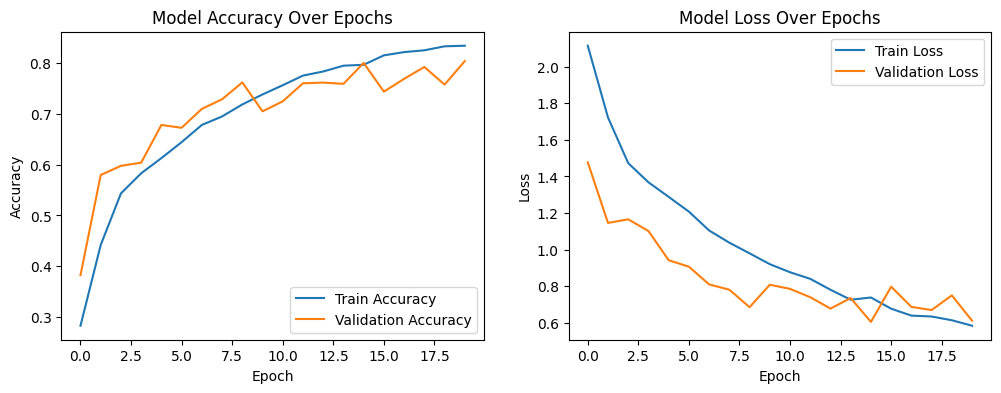

In [45]:
# Evaluate the trained model on the test data and report the final test accuracy
test_loss, test_acc = model_SSPCNN.evaluate(test_generator64)
print(f'Test accuracy: {test_acc:.4f}')

# Visualize model performance over training epochs

plt.figure(figsize=(12, 4))  # Create a figure with two side-by-side plots

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_SSPCNN.history['accuracy'], label='Train Accuracy')
plt.plot(history_SSPCNN.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_SSPCNN.history['loss'], label='Train Loss')
plt.plot(history_SSPCNN.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.show()


In [46]:
# Generate predictions and evaluate model performance on the test set

# Ground truth class labels from the test generator
y_true = test_generator64.classes

# Predicted class labels from the model (converted from probabilities to class indices)
y_pred_SSPCNN = np.argmax(model_SSPCNN.predict(test_generator64), axis=1)

# Display a detailed classification report including precision, recall, F1-score, and support for each class
print("Classification Report:")
print(classification_report(y_true, y_pred_SSPCNN, target_names=test_generator64.class_indices.keys()))


675/675 [==============================] - 3s 5ms/step
Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.93      0.65      0.76       600
              Forest       0.94      0.92      0.93       600
HerbaceousVegetation       0.78      0.78      0.78       600
             Highway       0.57      0.73      0.64       500
          Industrial       0.89      0.94      0.91       500
             Pasture       0.80      0.70      0.74       400
       PermanentCrop       0.55      0.76      0.64       500
         Residential       0.92      0.93      0.93       600
               River       0.73      0.62      0.67       500
             SeaLake       0.98      0.92      0.95       600

            accuracy                           0.80      5400
           macro avg       0.81      0.79      0.80      5400
        weighted avg       0.82      0.80      0.80      5400



1/1 [==============================] - 0s 63ms/step


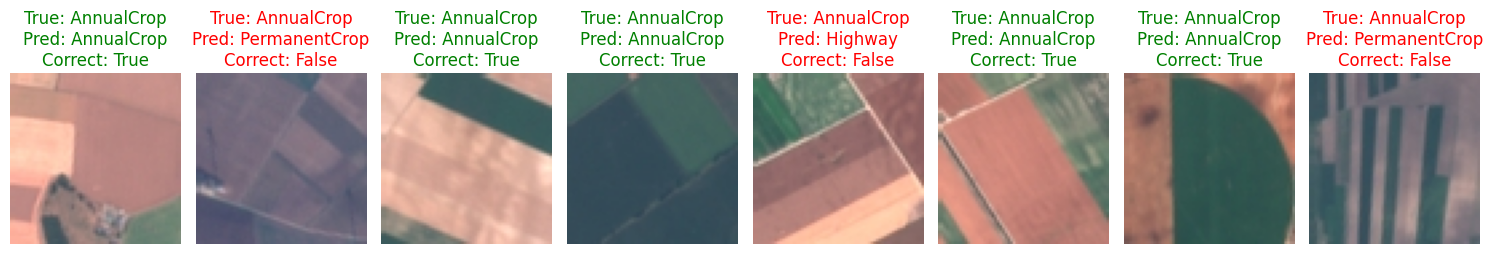

In [47]:
# Call the function to display a selection of model predictions
display_predictions(model_SSPCNN, test_generator64, num_examples=8)


In [48]:
# Save the model
model_SSPCNN.save('PsudoL_Models/eurosat_SSP_cnn_model.h5')

# Clear the memory
clear_model_memory(model_SSPCNN)

### 3.4.4 MobileNetV2 Pre-trained on ImageNet: Semi-Supervised Learning High Confidence Pseudo Labelling 

In [49]:
# Load the pre-trained MobileNetV2 model without the top classification layers
base_model_SSPMN = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape64)

# Freeze the base model layers to retain pre-trained features during training
base_model_SSPMN.trainable = False  

# Add custom classification head on top of the base model
x = base_model_SSPMN.output
x = GlobalAveragePooling2D()(x)            # Global Average Pooling to reduce spatial dimensions
x = Dense(128, activation='relu')(x)       # Fully connected layer with ReLU activation
x = Dropout(0.5)(x)                         # Dropout layer for regularization
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer for multi-class classification

# Construct the final model by combining the base and custom layers
model_SSPMN = Model(inputs=base_model_SSPMN.input, outputs=predictions)

# Compile the model with Adam optimizer and categorical cross-entropy loss
model_SSPMN.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'] 
) 


In [50]:
# Calculate steps per epoch using total_samples_SMN64
steps_per_epoch_SMN64 = total_samples_SMN64 // batch_size
validation_steps_SMN64 = test_generator64.samples // batch_size

# Train the model with early stopping
history_SSPMN = model_SSPMN.fit(
    combined_train_generator_SMN64,                # Training data
    steps_per_epoch=steps_per_epoch_SMN64,         # Manual step count
    epochs=epochs,
    validation_data=test_generator64,              # Validation data (still a generator)
    validation_steps=validation_steps_SMN64,
    class_weight=class_weights_dict_SMN64,         # Class weights from combined generator
    callbacks=[early_stopping]
)


Epoch 1/30
933/933 [==============================] - 33s 22ms/step - loss: 1.4096 - accuracy: 0.5761 - val_loss: 0.8327 - val_accuracy: 0.7163
Epoch 2/30
933/933 [==============================] - 19s 20ms/step - loss: 1.0922 - accuracy: 0.6681 - val_loss: 0.7237 - val_accuracy: 0.7543
Epoch 3/30
933/933 [==============================] - 19s 21ms/step - loss: 0.9971 - accuracy: 0.6933 - val_loss: 0.6580 - val_accuracy: 0.7822
Epoch 4/30
933/933 [==============================] - 19s 20ms/step - loss: 0.9526 - accuracy: 0.7053 - val_loss: 0.6740 - val_accuracy: 0.7769
Epoch 5/30
933/933 [==============================] - 19s 21ms/step - loss: 0.9074 - accuracy: 0.7212 - val_loss: 0.6604 - val_accuracy: 0.7806
Epoch 6/30
933/933 [==============================] - 20s 21ms/step - loss: 0.8923 - accuracy: 0.7279 - val_loss: 0.6413 - val_accuracy: 0.7872
Epoch 7/30
933/933 [==============================] - 19s 21ms/step - loss: 0.8917 - accuracy: 0.7296 - val_loss: 0.6486 - val_accuracy:

675/675 [==============================] - 6s 9ms/step - loss: 0.6027 - accuracy: 0.8070
Test accuracy: 0.8070


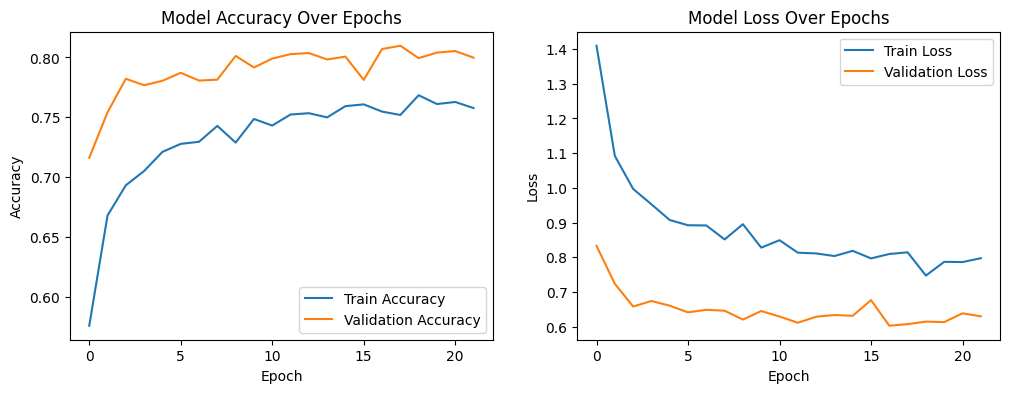

In [51]:
# Evaluate the trained model on the test data and report the final test accuracy
test_loss, test_acc = model_SSPMN.evaluate(test_generator64)
print(f'Test accuracy: {test_acc:.4f}')

# Visualize model performance over training epochs

plt.figure(figsize=(12, 4))  # Create a figure with two side-by-side plots

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_SSPMN.history['accuracy'], label='Train Accuracy')
plt.plot(history_SSPMN.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_SSPMN.history['loss'], label='Train Loss')
plt.plot(history_SSPMN.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.show()


In [52]:
# Generate predictions and evaluate model performance on the test set

# Ground truth class labels from the test generator
y_true = test_generator64.classes

# Predicted class labels from the model (converted from probabilities to class indices)
y_pred_model_SSPMN = np.argmax(model_SSPMN.predict(test_generator64), axis=1)

# Display a detailed classification report including precision, recall, F1-score, and support for each class
print("Classification Report:")
print(classification_report(y_true, y_pred_model_SSPMN, target_names=test_generator64.class_indices.keys()))


675/675 [==============================] - 6s 7ms/step
Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.89      0.79      0.84       600
              Forest       0.90      0.79      0.84       600
HerbaceousVegetation       0.68      0.84      0.75       600
             Highway       0.71      0.76      0.73       500
          Industrial       0.88      0.90      0.89       500
             Pasture       0.69      0.77      0.73       400
       PermanentCrop       0.72      0.75      0.74       500
         Residential       0.88      0.82      0.85       600
               River       0.75      0.76      0.75       500
             SeaLake       0.98      0.88      0.93       600

            accuracy                           0.81      5400
           macro avg       0.81      0.80      0.80      5400
        weighted avg       0.82      0.81      0.81      5400



1/1 [==============================] - 1s 657ms/step


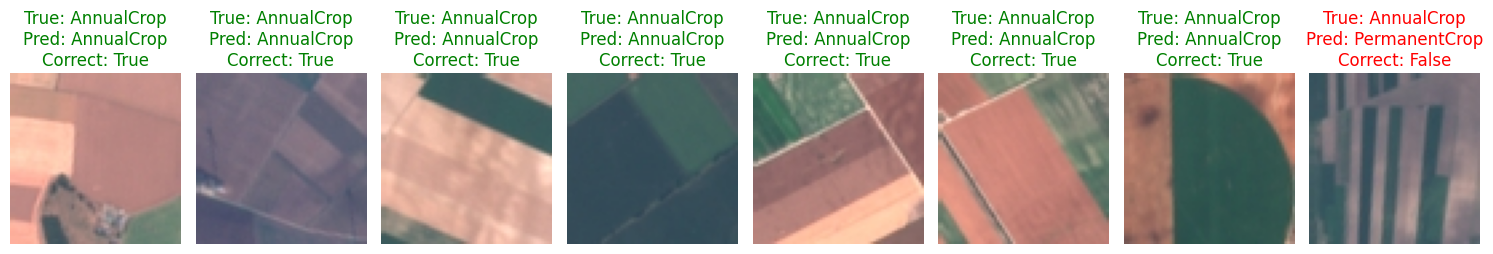

In [53]:
# Call the function to display a selection of model predictions
display_predictions(model_SSPMN, test_generator64, num_examples=8)


In [54]:
# Save the fine-tuned model
model_SMN.save('PsudoL_Models/eurosat_SSP_mobilenetv2_model.h5')

# Clear the memory
clear_model_memory(model_SMN)

### 3.4.5 EfficientNetB0 Lightweight variant pre-trained on ImageNet: Semi-Supervised Learning High Confidence Pseudo Labelling

In [55]:
# Load the pre-trained EfficientNetB0 model without the top classification layers
base_model_SSPEN = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape224)

# Freeze the base model layers to retain pre-trained features during training
base_model_SSPEN.trainable = False  

# Add custom classification head on top of the base model
x = base_model_SSPEN.output
x = GlobalAveragePooling2D()(x)            # Global Average Pooling to reduce spatial dimensions
x = Dense(128, activation='relu')(x)       # Fully connected layer with ReLU activation
x = Dropout(0.5)(x)                         # Dropout layer for regularization
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer for multi-class classification

# Construct the final model by combining the base and custom layers
model_SSPEN = Model(inputs=base_model_SSPEN.input, outputs=predictions)

# Compile the model with Adam optimizer and categorical cross-entropy loss
model_SSPEN.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [56]:
# Calculate steps using total_samples_SEN224
steps_per_epoch_SEN224 = total_samples_SEN224 // batch_size
validation_steps_SEN224 = test_generator224.samples // batch_size

# Train the model with early stopping
history_SSPEN = model_SSPEN.fit(
    combined_train_generator_SEN224,                # Training dataset (tf.data.Dataset)
    steps_per_epoch=steps_per_epoch_SEN224,         # Total steps per epoch
    epochs=epochs,
    validation_data=test_generator224,              # Validation data (Keras generator)
    validation_steps=validation_steps_SEN224,
    class_weight=class_weights_dict_SEN224,         # Combined class weights
    callbacks=[early_stopping]
)


Epoch 1/30
1208/1208 [==============================] - 163s 79ms/step - loss: 0.6482 - accuracy: 0.7832 - val_loss: 0.5329 - val_accuracy: 0.8052
Epoch 2/30
1208/1208 [==============================] - 95s 79ms/step - loss: 0.4145 - accuracy: 0.8619 - val_loss: 0.5965 - val_accuracy: 0.7939
Epoch 3/30
1208/1208 [==============================] - 93s 77ms/step - loss: 0.3500 - accuracy: 0.8833 - val_loss: 0.5509 - val_accuracy: 0.8124
Epoch 4/30
1208/1208 [==============================] - 91s 75ms/step - loss: 0.3294 - accuracy: 0.8926 - val_loss: 0.4149 - val_accuracy: 0.8519
Epoch 5/30
1208/1208 [==============================] - 91s 75ms/step - loss: 0.3118 - accuracy: 0.8963 - val_loss: 0.3607 - val_accuracy: 0.8794
Epoch 6/30
1208/1208 [==============================] - 89s 74ms/step - loss: 0.2882 - accuracy: 0.9029 - val_loss: 0.4076 - val_accuracy: 0.8643
Epoch 7/30
1208/1208 [==============================] - 87s 72ms/step - loss: 0.2767 - accuracy: 0.9077 - val_loss: 0.3765 

675/675 [==============================] - 11s 16ms/step - loss: 0.3607 - accuracy: 0.8794
Test accuracy: 0.8794


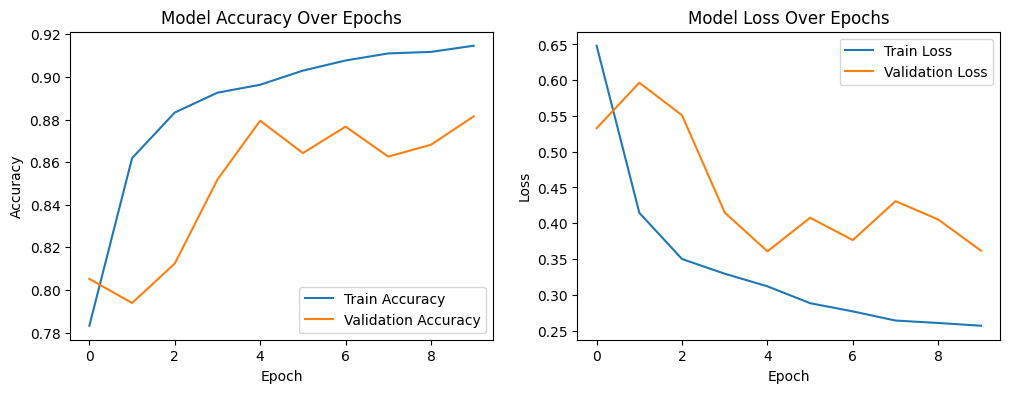

In [57]:
# Evaluate the trained model on the test data and report the final test accuracy
test_loss, test_acc = model_SSPEN.evaluate(test_generator224)
print(f'Test accuracy: {test_acc:.4f}')

# Visualize model performance over training epochs

plt.figure(figsize=(12, 4))  # Create a figure with two side-by-side plots

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_SSPEN.history['accuracy'], label='Train Accuracy')
plt.plot(history_SSPEN.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_SSPEN.history['loss'], label='Train Loss')
plt.plot(history_SSPEN.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.show()


In [58]:
# Generate predictions and evaluate model performance on the test set

# Ground truth class labels from the test generator
y_true = test_generator224.classes

# Predicted class labels from the model (converted from probabilities to class indices)
y_pred_model_SSPEN = np.argmax(model_SSPEN.predict(test_generator224), axis=1)

# Display a detailed classification report including precision, recall, F1-score, and support for each class
print("Classification Report:")
print(classification_report(y_true, y_pred_model_SSPEN, target_names=test_generator224.class_indices.keys()))


675/675 [==============================] - 11s 15ms/step
Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.91      0.92      0.91       600
              Forest       0.92      0.96      0.94       600
HerbaceousVegetation       0.75      0.92      0.83       600
             Highway       0.78      0.88      0.83       500
          Industrial       0.95      0.81      0.88       500
             Pasture       0.91      0.82      0.86       400
       PermanentCrop       0.87      0.74      0.80       500
         Residential       0.86      0.96      0.91       600
               River       0.91      0.76      0.83       500
             SeaLake       0.99      0.94      0.96       600

            accuracy                           0.88      5400
           macro avg       0.89      0.87      0.88      5400
        weighted avg       0.89      0.88      0.88      5400



1/1 [==============================] - 1s 656ms/step


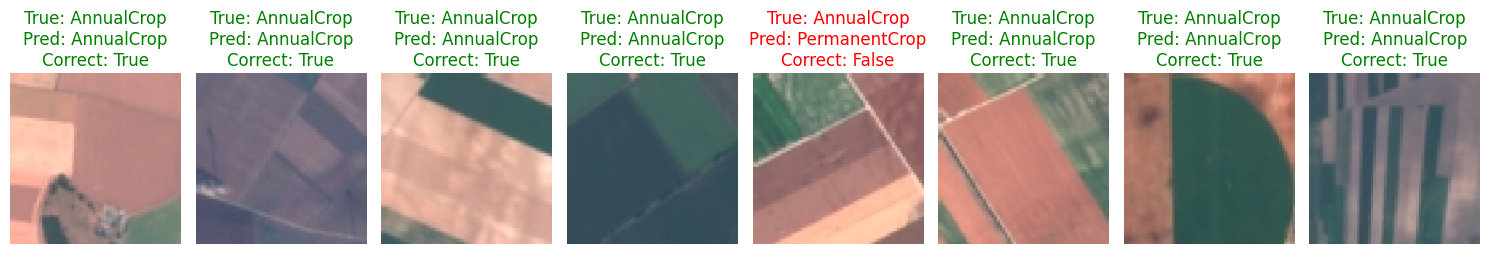

In [59]:
# Call the function to display a selection of model predictions
display_predictions_effi(model_SSPMN, test_generator224, num_examples=8)


In [60]:
# Save the fine-tuned model
tf.saved_model.save(model_SSPMN, "PsudoL_Models/efficientnet_model_SSP")

# Clear the memory
clear_model_memory(model_SSPMN)

INFO:tensorflow:Assets written to: PsudoL_Models/efficientnet_model_SSP\assets


INFO:tensorflow:Assets written to: PsudoL_Models/efficientnet_model_SSP\assets


### 3.4.6 Test Overview

In [61]:
# Compute metrics for each model
results_SSP = {
    "Baseline CNN_SSP": get_metrics(y_true, y_pred_SSPCNN),
    "MobileNetV2_SSP": get_metrics(y_true, y_pred_model_SSPMN),
    "EfficientNetB0_SSP": get_metrics(y_true, y_pred_model_SSPEN)
}

# Create and display DataFrame
df_results_SSP = pd.DataFrame(results_SSP).T  # Transpose so models are rows
df_results_SSP = df_results_SSP.round(6)      # Round to match your format
print(df_results_SSP)

                    Accuracy  Precision    Recall  F1-Score
Baseline CNN_SSP    0.800185   0.819009  0.800185  0.803527
MobileNetV2_SSP     0.807037   0.817098  0.807037  0.809683
EfficientNetB0_SSP  0.879444   0.886407  0.879444  0.879306


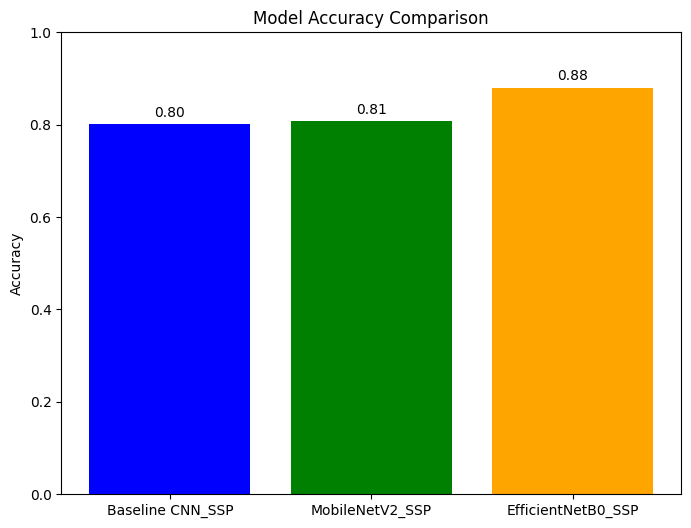

In [62]:
# Model names and accuracies
models_SSP = ['Baseline CNN_SSP', 'MobileNetV2_SSP', 'EfficientNetB0_SSP']
accuracies_SSP = [results_SSP[m]['Accuracy'] for m in models_SSP]

# Create a bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(models_SSP, accuracies_SSP, color=['blue', 'green', 'orange'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add accuracy labels on top of bars
for bar, acc in zip(bars, accuracies_SSP):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f"{acc:.2f}", ha='center', va='bottom', fontsize=10)

plt.show()

In [63]:
clear_gpu_memory()

## 3.5 Model Training (Semi-Supervised Learning - FixMatch)

## 3.5.1 Data Augmentation

In [64]:
# ============================================
# Data Generators for CNN / MobileNet (64x64)
# ============================================

# Weak augmentation (used for both supervised and FixMatch weak views)
fixmatch_weak = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Strong augmentation (used for FixMatch strong views)
fixmatch_strong = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,  # or remove
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
    # vertical_flip removed
)


# Unlabeled (FixMatch weak and strong views)
fixmatch_unlabeled_weak_CNN_MobileNet = fixmatch_weak.flow_from_directory(
    os.path.dirname(unlabeled_dir),
    classes=[os.path.basename(unlabeled_dir)],
    target_size=img_size64,
    batch_size=batch_size,
    class_mode=None,
    shuffle=True,
    seed=seed
)

fixmatch_unlabeled_strong_CNN_MobileNet = fixmatch_strong.flow_from_directory(
    os.path.dirname(unlabeled_dir),
    classes=[os.path.basename(unlabeled_dir)],
    target_size=img_size64,
    batch_size=batch_size,
    class_mode=None,
    shuffle=True,
    seed=seed
)

# Evaluation
# test_generator64 --> from previous runs will be used



# ============================================
# Data Generators for EfficientNet (224x224)
# ============================================

# Weak augmentation with EfficientNet preprocessing
fixmatch_weak_effnet = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Strong augmentation with EfficientNet preprocessing
fixmatch_strong_effnet = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True
)

# Unlabeled (FixMatch weak and strong views)
fixmatch_unlabeled_weak_EfficientNet = fixmatch_weak_effnet.flow_from_directory(
    os.path.dirname(unlabeled_dir),
    classes=[os.path.basename(unlabeled_dir)],
    target_size=img_size224,
    batch_size=batch_size,
    class_mode=None,
    shuffle=True,
    seed=seed
)

fixmatch_unlabeled_strong_EfficientNet = fixmatch_strong_effnet.flow_from_directory(
    os.path.dirname(unlabeled_dir),
    classes=[os.path.basename(unlabeled_dir)],
    target_size=img_size224,
    batch_size=batch_size,
    class_mode=None,
    shuffle=True,
    seed=seed
)

# Evaluation
# test_generaton224 --> from previous runs will be used

Found 9720 images belonging to 1 classes.
Found 9720 images belonging to 1 classes.
Found 9720 images belonging to 1 classes.
Found 9720 images belonging to 1 classes.


## 3.5.2 FixMatch Training Function

In [65]:
def train_fixmatch_model(model, 
                         labeled_generator, 
                         unlabeled_weak_generator, 
                         unlabeled_strong_generator, 
                         val_generator, 
                         epochs=epochs,  
                         lambda_u=0.5, 
                         confidence_threshold=0.8,
                         class_weights=None,
                         patience=4):

    history = {
        'train_accuracy': [],   
        'val_accuracy': [],
        'val_loss': [],
        'supervised_loss': [],
        'unsupervised_loss': [],
        'total_loss': []
    }

    best_val_loss = float('inf')
    best_weights = None
    wait = 0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        progbar = tf.keras.utils.Progbar(len(labeled_generator))

        epoch_sup_loss = []
        epoch_unsup_loss = []
        epoch_total_loss = []
        correct_preds = 0
        total_preds = 0

        for step in range(len(labeled_generator)):
            start_time = time.time()  # ⏱ Start timing

            x_labeled, y_labeled = labeled_generator[step]
            x_weak = unlabeled_weak_generator[step]
            x_strong = unlabeled_strong_generator[step]

            with tf.GradientTape() as tape:
                y_pred_labeled = model(x_labeled, training=True)
                pred_labels = tf.argmax(y_pred_labeled, axis=1)
                true_labels = tf.argmax(y_labeled, axis=1)
                correct_preds += tf.reduce_sum(tf.cast(pred_labels == true_labels, tf.float32)).numpy()
                total_preds += len(y_labeled)

                if class_weights:
                    sample_weights = tf.reduce_sum(
                        y_labeled * tf.convert_to_tensor(
                            [class_weights[i] for i in range(len(class_weights))], dtype=tf.float32
                        ),
                        axis=1
                    )
                    loss_labeled = tf.reduce_mean(
                        tf.keras.losses.categorical_crossentropy(y_labeled, y_pred_labeled) * sample_weights
                    )
                else:
                    loss_labeled = tf.reduce_mean(
                        tf.keras.losses.categorical_crossentropy(y_labeled, y_pred_labeled)
                    )

                pseudo_probs = model(x_weak, training=False)
                pseudo_labels = tf.argmax(pseudo_probs, axis=1)
                confidences = tf.reduce_max(pseudo_probs, axis=1)
                mask = tf.cast(confidences >= confidence_threshold, tf.float32)

                y_pred_strong = model(x_strong, training=True)
                loss_unlabeled = tf.reduce_sum(
                    tf.keras.losses.sparse_categorical_crossentropy(pseudo_labels, y_pred_strong) * mask
                ) / (tf.reduce_sum(mask) + 1e-7)

                total_loss = loss_labeled + lambda_u * loss_unlabeled

            grads = tape.gradient(total_loss, model.trainable_variables)
            model.optimizer.apply_gradients(zip(grads, model.trainable_variables))

            step_duration = time.time() - start_time  # ⏱ End timing
            #print(f"Step {step + 1}/{len(labeled_generator)} - Duration: {step_duration:.2f}s")

            epoch_sup_loss.append(loss_labeled.numpy())
            epoch_unsup_loss.append(loss_unlabeled.numpy())
            epoch_total_loss.append(total_loss.numpy())

            progbar.update(step + 1)

        train_acc = correct_preds / total_preds
        val_loss, val_acc = model.evaluate(val_generator, verbose=0)

        print(f"\n[Epoch {epoch + 1}] Results: "
              f"Train Accuracy: {train_acc:.4f}   "
              f"Val Loss: {val_loss:.4f}   "
              f"Val Accuracy: {val_acc:.4f}")

        history['train_accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        history['val_loss'].append(val_loss)
        history['supervised_loss'].append(np.mean(epoch_sup_loss))
        history['unsupervised_loss'].append(np.mean(epoch_unsup_loss))
        history['total_loss'].append(np.mean(epoch_total_loss))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = model.get_weights()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"\nEarly stopping triggered at epoch {epoch + 1}. Restoring best weights.")
                model.set_weights(best_weights)
                break

    return model, history


In [66]:
# class_weights_dict from original training set will be used.

### 3.5.3 CNN: Semi-Supervised Learning with FixMatch

In [67]:
clear_gpu_memory()


In [68]:
# Instantiate the CNN model for FixMatch
model_FixMatch_CNN = create_cnn_model(input_shape64, num_classes)

# Instantiate the CNN model
model_FixMatch_CNN = create_cnn_model(input_shape64, num_classes)

# Compile the model with Adam optimizer and categorical cross-entropy loss
model_FixMatch_CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [69]:

model_FixMatch_CNN, history_fixmatch_cnn = train_fixmatch_model(
    model_FixMatch_CNN,
    train_generator64,
    fixmatch_unlabeled_weak_CNN_MobileNet,
    fixmatch_unlabeled_strong_CNN_MobileNet,
    test_generator64)


Epoch 1/30
270/270 [==============================] - 32s 117ms/step

[Epoch 1] Results: Train Accuracy: 0.2435   Val Loss: 1.5618   Val Accuracy: 0.3589

Epoch 2/30
270/270 [==============================] - 21s 79ms/step

[Epoch 2] Results: Train Accuracy: 0.3597   Val Loss: 1.3526   Val Accuracy: 0.4670

Epoch 3/30
270/270 [==============================] - 21s 79ms/step

[Epoch 3] Results: Train Accuracy: 0.4546   Val Loss: 1.3081   Val Accuracy: 0.5159

Epoch 4/30
270/270 [==============================] - 21s 79ms/step

[Epoch 4] Results: Train Accuracy: 0.5032   Val Loss: 1.1518   Val Accuracy: 0.5909

Epoch 5/30
270/270 [==============================] - 21s 79ms/step

[Epoch 5] Results: Train Accuracy: 0.5486   Val Loss: 1.0781   Val Accuracy: 0.6150

Epoch 6/30
270/270 [==============================] - 21s 79ms/step

[Epoch 6] Results: Train Accuracy: 0.5644   Val Loss: 1.2227   Val Accuracy: 0.5633

Epoch 7/30
270/270 [==============================] - 21s 79ms/step

[Epoc

675/675 [==============================] - 4s 5ms/step - loss: 0.6411 - accuracy: 0.7715
Test accuracy: 0.7715


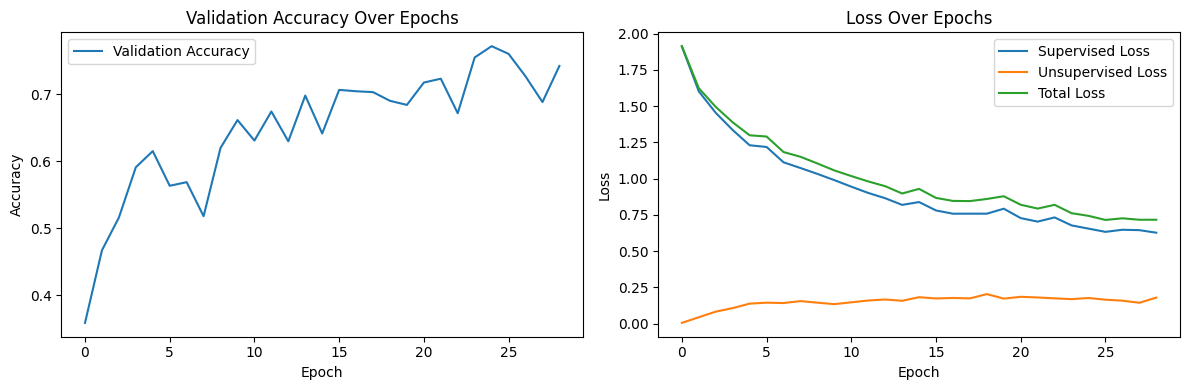

In [70]:
# Evaluate the trained model on the test data and report the final test accuracy
test_loss, test_acc = model_FixMatch_CNN.evaluate(test_generator64)
print(f'Test accuracy: {test_acc:.4f}')

# Plotting
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_fixmatch_cnn['val_accuracy'], label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_fixmatch_cnn['supervised_loss'], label='Supervised Loss')
plt.plot(history_fixmatch_cnn['unsupervised_loss'], label='Unsupervised Loss')
plt.plot(history_fixmatch_cnn['total_loss'], label='Total Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [71]:
# Generate predictions and evaluate model performance on the test set

# Ground truth class labels from the test generator
y_true = test_generator64.classes

# Predicted class labels from the model (converted from probabilities to class indices)
y_pred_FixMatch_CNN = np.argmax(model_FixMatch_CNN.predict(test_generator64), axis=1)

# Display a detailed classification report including precision, recall, F1-score, and support for each class
print("Classification Report:")
print(classification_report(y_true, y_pred_FixMatch_CNN, target_names=test_generator64.class_indices.keys()))


675/675 [==============================] - 3s 5ms/step
Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.90      0.71      0.80       600
              Forest       0.89      0.93      0.91       600
HerbaceousVegetation       0.77      0.62      0.69       600
             Highway       0.48      0.65      0.55       500
          Industrial       0.90      0.90      0.90       500
             Pasture       0.66      0.77      0.71       400
       PermanentCrop       0.63      0.53      0.57       500
         Residential       0.82      0.96      0.88       600
               River       0.70      0.67      0.68       500
             SeaLake       0.98      0.93      0.95       600

            accuracy                           0.77      5400
           macro avg       0.77      0.77      0.76      5400
        weighted avg       0.78      0.77      0.77      5400



1/1 [==============================] - 0s 73ms/step


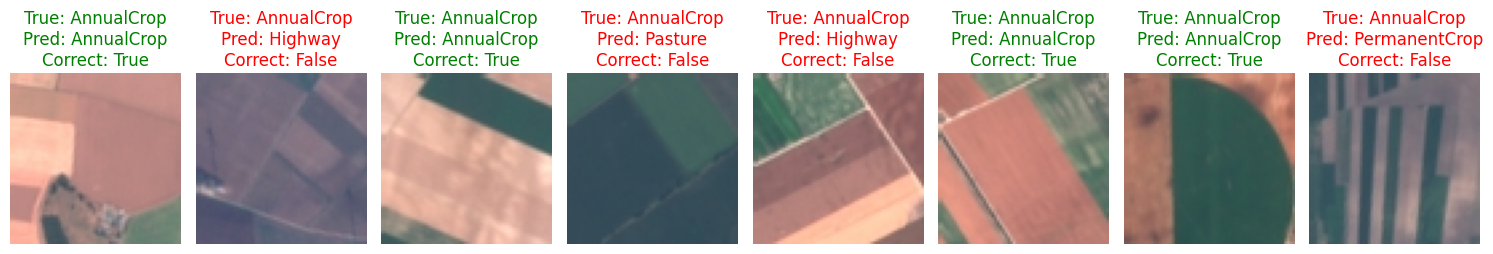

In [72]:
# Call the function to display a selection of model predictions
display_predictions(model_FixMatch_CNN, test_generator64, num_examples=8)

In [73]:
# Save the model and clear memory
model_FixMatch_CNN.save('FixM_Models/fixmatch_cnn_model.h5')
clear_model_memory(model_FixMatch_CNN)

### 3.5.4 MobileNetV2 Pre-trained on ImageNet: Semi-Supervised with FixMatch


In [74]:
# Load the pre-trained MobileNetV2 model without the top classification layers
base_model_FixMatch_MobileNet = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape64)

# Freeze the base model layers to retain pre-trained features during training
base_model_FixMatch_MobileNet.trainable = False  

# Add custom classification head on top of the base model
x = base_model_FixMatch_MobileNet.output
x = GlobalAveragePooling2D()(x)            # Global Average Pooling to reduce spatial dimensions
x = Dense(128, activation='relu')(x)       # Fully connected layer with ReLU activation
x = Dropout(0.5)(x)                         # Dropout layer for regularization
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer for multi-class classification

# Construct the final model by combining the base and custom layers
model_FixMatch_MobileNet = Model(inputs=base_model_FixMatch_MobileNet.input, outputs=predictions)

# Compile the model with Adam optimizer and categorical cross-entropy loss
model_FixMatch_MobileNet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [75]:
clear_gpu_memory()
model_FixMatch_MobileNet, history_FixMatch_MobileNet = train_fixmatch_model(
    model_FixMatch_MobileNet,
    train_generator64,
    fixmatch_unlabeled_weak_CNN_MobileNet,
    fixmatch_unlabeled_strong_CNN_MobileNet,
    test_generator64,
    epochs=epochs,
    lambda_u=.5,
    confidence_threshold=0.85,
    class_weights=None,
    patience=4)



Epoch 1/30
270/270 [==============================] - 97s 357ms/step

[Epoch 1] Results: Train Accuracy: 0.4694   Val Loss: 1.0281   Val Accuracy: 0.6328

Epoch 2/30
270/270 [==============================] - 96s 355ms/step

[Epoch 2] Results: Train Accuracy: 0.5921   Val Loss: 0.8623   Val Accuracy: 0.7046

Epoch 3/30
270/270 [==============================] - 96s 357ms/step

[Epoch 3] Results: Train Accuracy: 0.6347   Val Loss: 0.8986   Val Accuracy: 0.6937

Epoch 4/30
270/270 [==============================] - 109s 405ms/step

[Epoch 4] Results: Train Accuracy: 0.6611   Val Loss: 0.8153   Val Accuracy: 0.7211

Epoch 5/30
270/270 [==============================] - 99s 366ms/step

[Epoch 5] Results: Train Accuracy: 0.6625   Val Loss: 0.7261   Val Accuracy: 0.7513

Epoch 6/30
270/270 [==============================] - 97s 360ms/step

[Epoch 6] Results: Train Accuracy: 0.6833   Val Loss: 0.7357   Val Accuracy: 0.7450

Epoch 7/30
270/270 [==============================] - 96s 355ms/step

675/675 [==============================] - 7s 10ms/step - loss: 0.6378 - accuracy: 0.7828
Test accuracy: 0.7828


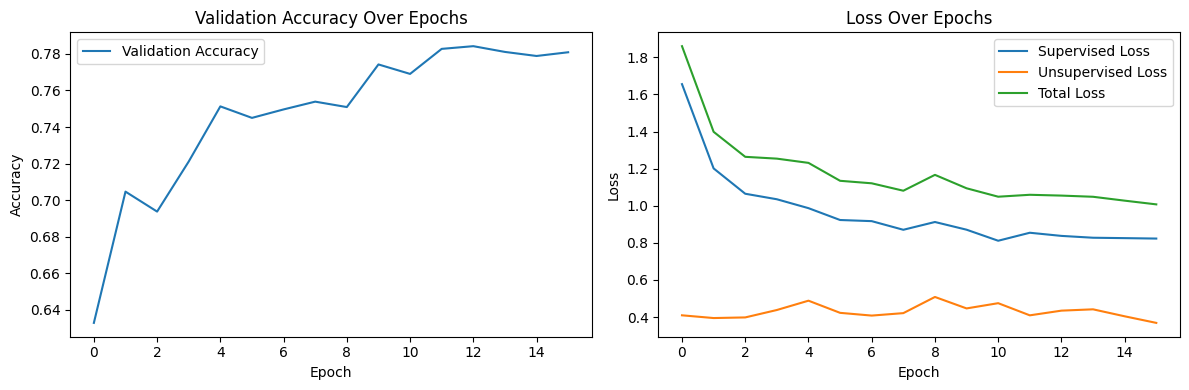

In [76]:
# Evaluate the trained model on the test data and report the final test accuracy
test_loss, test_acc = model_FixMatch_MobileNet.evaluate(test_generator64)
print(f'Test accuracy: {test_acc:.4f}')

# Plotting
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_FixMatch_MobileNet['val_accuracy'], label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_FixMatch_MobileNet['supervised_loss'], label='Supervised Loss')
plt.plot(history_FixMatch_MobileNet['unsupervised_loss'], label='Unsupervised Loss')
plt.plot(history_FixMatch_MobileNet['total_loss'], label='Total Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [77]:
# Generate predictions and evaluate model performance on the test set

# Ground truth class labels from the test generator
y_true = test_generator64.classes

# Predicted class labels from the model (converted from probabilities to class indices)
y_pred_FixMatch_MobileNet = np.argmax(model_FixMatch_MobileNet.predict(test_generator64), axis=1)

# Display a detailed classification report including precision, recall, F1-score, and support for each class
print("Classification Report:")
print(classification_report(y_true, y_pred_FixMatch_MobileNet, target_names=test_generator64.class_indices.keys()))


675/675 [==============================] - 7s 9ms/step
Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.85      0.83      0.84       600
              Forest       0.81      0.90      0.85       600
HerbaceousVegetation       0.76      0.70      0.73       600
             Highway       0.65      0.67      0.66       500
          Industrial       0.83      0.91      0.87       500
             Pasture       0.72      0.63      0.67       400
       PermanentCrop       0.68      0.65      0.67       500
         Residential       0.75      0.91      0.82       600
               River       0.74      0.67      0.70       500
             SeaLake       0.98      0.88      0.93       600

            accuracy                           0.78      5400
           macro avg       0.78      0.77      0.77      5400
        weighted avg       0.78      0.78      0.78      5400



1/1 [==============================] - 1s 913ms/step


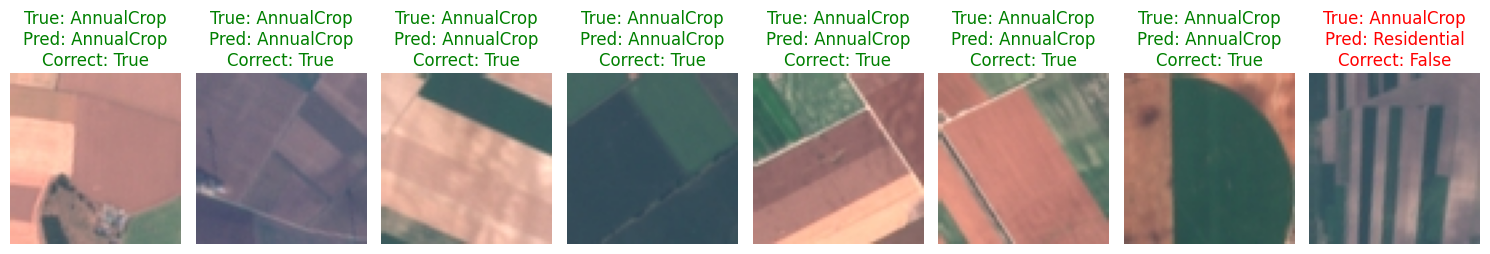

In [78]:
# Call the function to display a selection of model predictions
display_predictions(model_FixMatch_MobileNet, test_generator64, num_examples=8)

In [79]:
# Save the model and clear memory
model_FixMatch_MobileNet.save('FixM_Models/fixmatch_MobileNet_model.h5')
clear_model_memory(model_FixMatch_MobileNet)

### 3.5.4 EfficientNetB0 Lightweight variant pre-trained on ImageNet: Supervised Learning with FixMatch


In [80]:
clear_gpu_memory()

# Load the pre-trained EfficientNetB0 model without the top classification layers
base_model_FixMatch_Effici = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape224)

# Freeze the base model layers to retain pre-trained features during training
base_model_FixMatch_Effici.trainable = False  

# Add custom classification head on top of the base model
x = base_model_FixMatch_Effici.output
x = GlobalAveragePooling2D()(x)            # Global Average Pooling to reduce spatial dimensions
x = Dense(128, activation='relu')(x)       # Fully connected layer with ReLU activation
x = Dropout(0.5)(x)                         # Dropout layer for regularization
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer for multi-class classification

# Construct the final model by combining the base and custom layers
model_FixMatch_Effici = Model(inputs=base_model_FixMatch_Effici.input, outputs=predictions)

# Compile the model with Adam optimizer and categorical cross-entropy loss
model_FixMatch_Effici.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [81]:
clear_gpu_memory()

# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy('mixed_float16')
# mixed_precision.set_global_policy('float32')

model_FixMatch_Effici, history_FixMatch_Effici = train_fixmatch_model(
    model_FixMatch_Effici,
    train_generator224,
    fixmatch_unlabeled_weak_EfficientNet,
    fixmatch_unlabeled_strong_EfficientNet,
    test_generator224
)



Epoch 1/30
270/270 [==============================] - 278s 1s/step

[Epoch 1] Results: Train Accuracy: 0.6463   Val Loss: 0.8176   Val Accuracy: 0.6993

Epoch 2/30
270/270 [==============================] - 268s 992ms/step

[Epoch 2] Results: Train Accuracy: 0.8088   Val Loss: 0.5822   Val Accuracy: 0.7891

Epoch 3/30
270/270 [==============================] - 262s 971ms/step

[Epoch 3] Results: Train Accuracy: 0.8315   Val Loss: 0.5178   Val Accuracy: 0.8128

Epoch 4/30
270/270 [==============================] - 265s 981ms/step

[Epoch 4] Results: Train Accuracy: 0.8718   Val Loss: 0.4893   Val Accuracy: 0.8243

Epoch 5/30
270/270 [==============================] - 277s 1s/step

[Epoch 5] Results: Train Accuracy: 0.8500   Val Loss: 0.4349   Val Accuracy: 0.8517

Epoch 6/30
270/270 [==============================] - 295s 1s/step

[Epoch 6] Results: Train Accuracy: 0.8782   Val Loss: 0.4955   Val Accuracy: 0.8376

Epoch 7/30
270/270 [==============================] - 272s 1s/step

[Epo

675/675 [==============================] - 16s 24ms/step - loss: 0.4349 - accuracy: 0.8517
Test accuracy: 0.8517


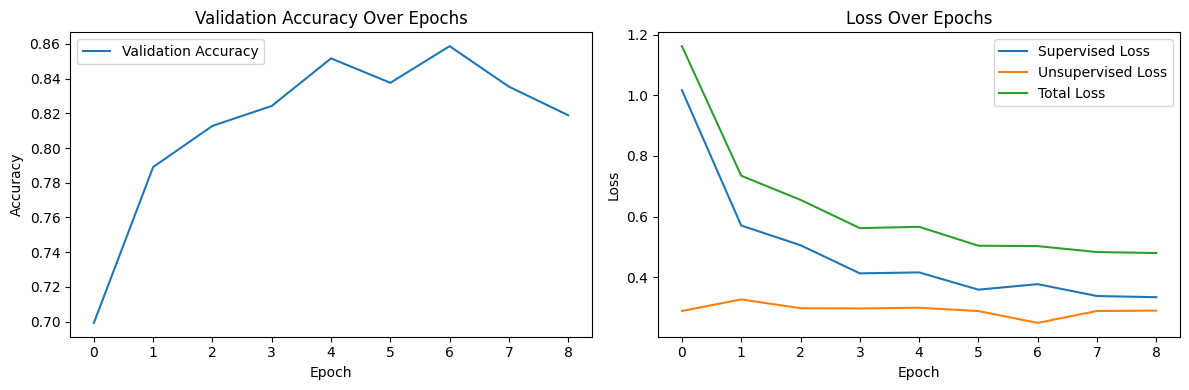

In [82]:
# Evaluate the trained model on the test data and report the final test accuracy
test_loss, test_acc = model_FixMatch_Effici.evaluate(test_generator224)
print(f'Test accuracy: {test_acc:.4f}')

# Plotting
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_FixMatch_Effici['val_accuracy'], label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_FixMatch_Effici['supervised_loss'], label='Supervised Loss')
plt.plot(history_FixMatch_Effici['unsupervised_loss'], label='Unsupervised Loss')
plt.plot(history_FixMatch_Effici['total_loss'], label='Total Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [83]:
# Generate predictions and evaluate model performance on the test set

# Ground truth class labels from the test generator
y_true = test_generator64.classes

# Predicted class labels from the model (converted from probabilities to class indices)
y_pred_FixMatch_Effici = np.argmax(model_FixMatch_Effici.predict(test_generator224), axis=1)

# Display a detailed classification report including precision, recall, F1-score, and support for each class
print("Classification Report:")
print(classification_report(y_true, y_pred_FixMatch_Effici, target_names=test_generator224.class_indices.keys()))


675/675 [==============================] - 17s 23ms/step
Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.89      0.89      0.89       600
              Forest       0.88      0.97      0.92       600
HerbaceousVegetation       0.70      0.89      0.78       600
             Highway       0.73      0.85      0.79       500
          Industrial       0.93      0.77      0.84       500
             Pasture       0.92      0.77      0.84       400
       PermanentCrop       0.87      0.66      0.75       500
         Residential       0.84      0.95      0.89       600
               River       0.88      0.72      0.79       500
             SeaLake       1.00      0.95      0.97       600

            accuracy                           0.85      5400
           macro avg       0.86      0.84      0.85      5400
        weighted avg       0.86      0.85      0.85      5400



1/1 [==============================] - 1s 1s/step


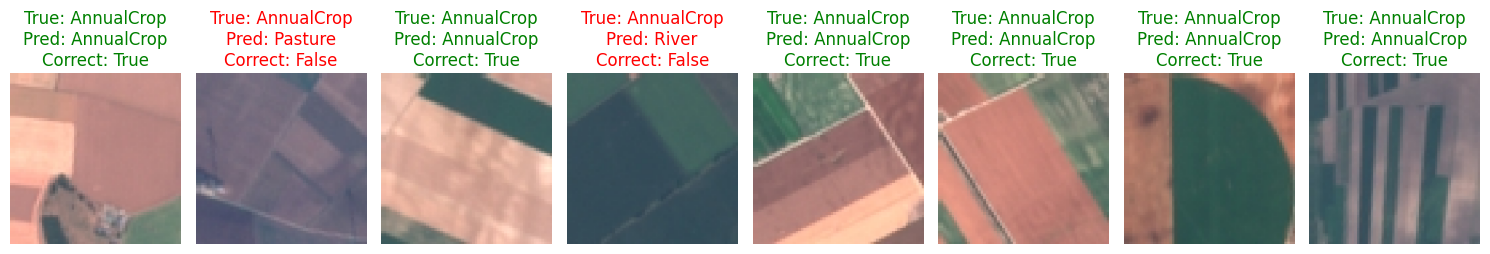

In [84]:
# Call the function to display a selection of model predictions
display_predictions_effi(model_FixMatch_Effici, test_generator224, num_examples=8)


In [85]:
# Save the model and clear memory
tf.saved_model.save(model_FixMatch_Effici, "FixM_Models/fixmatch_Effici_model")

clear_model_memory(model_FixMatch_Effici)

INFO:tensorflow:Assets written to: FixM_Models/fixmatch_Effici_model\assets


INFO:tensorflow:Assets written to: FixM_Models/fixmatch_Effici_model\assets


### 3.5.5 Test Overview

In [86]:
# Compute metrics for each model
results_SSFIX = {
    "Baseline CNN_SSFIX": get_metrics(y_true, y_pred_FixMatch_CNN),
    "MobileNetV2_SSFIX": get_metrics(y_true, y_pred_FixMatch_MobileNet),
    "EfficientNetB0_SSFIX": get_metrics(y_true, y_pred_FixMatch_Effici)
}

# Create and display DataFrame
df_results_SSFIX = pd.DataFrame(results_SSFIX).T  # Transpose so models are rows
df_results_SSFIX = df_results_SSFIX.round(6)      # Round to ensure easy visibility
print(df_results_SSFIX)

                      Accuracy  Precision    Recall  F1-Score
Baseline CNN_SSFIX    0.771481   0.783599  0.771481  0.772719
MobileNetV2_SSFIX     0.782778   0.783808  0.782778  0.781120
EfficientNetB0_SSFIX  0.851667   0.861796  0.851667  0.850923


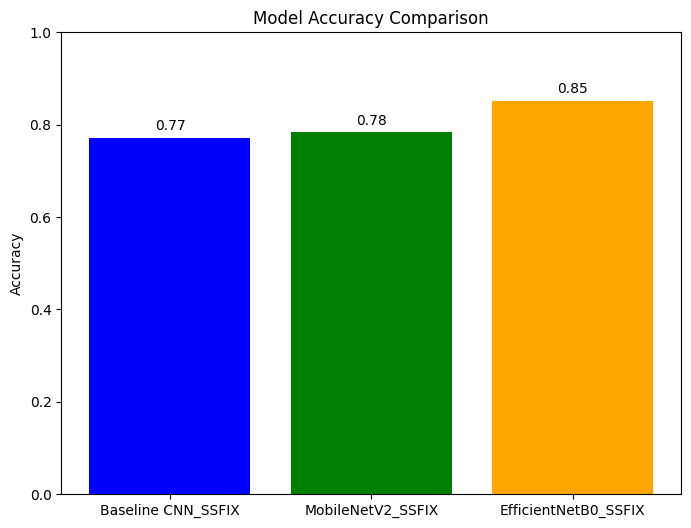

In [87]:
# Model names and accuracies
models_SSFIX = ['Baseline CNN_SSFIX', 'MobileNetV2_SSFIX', 'EfficientNetB0_SSFIX']
accuracies_SSFIX = [results_SSFIX[m]['Accuracy'] for m in models_SSFIX]

# Create a bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(models_SSFIX, accuracies_SSFIX, color=['blue', 'green', 'orange'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add accuracy labels on top of bars
for bar, acc in zip(bars, accuracies_SSFIX):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f"{acc:.2f}", ha='center', va='bottom', fontsize=10)

plt.show()

# 4 Overall Comparison

In [91]:
combined_results = pd.concat([df_results_SSFIX, df_results_SSP, df_results], axis=0)

# Move the index into a column to allow for sorting
combined_results = combined_results.reset_index()

# Define custom sort
custom_order = [
    "Baseline CNN", "Baseline CNN_SSP", "Baseline CNN_SSFIX",
    "MobileNetV2", "MobileNetV2_SSP", "MobileNetV2_SSFIX",
    "EfficientNetB0", "EfficientNetB0_SSP", "EfficientNetB0_SSFIX"
]

# Convert the 'index' column to a categorical type using the custom order
combined_results['index'] = pd.Categorical(combined_results['index'], categories=custom_order, ordered=True)

# Sort by the new column
combined_results_sorted = combined_results.sort_values('index').reset_index(drop=True)

combined_results_sorted

,index,Accuracy,Precision,Recall,F1-Score
0,Baseline CNN,0.764074,0.767200,0.764074,0.760636
1,Baseline CNN_SSP,0.800185,0.819009,0.800185,0.803527
2,Baseline CNN_SSFIX,0.771481,0.783599,0.771481,0.772719
3,MobileNetV2,0.789630,0.795919,0.789630,0.791289
4,MobileNetV2_SSP,0.807037,0.817098,0.807037,0.809683
5,MobileNetV2_SSFIX,0.782778,0.783808,0.782778,0.781120
6,EfficientNetB0,0.848519,0.866072,0.848519,0.851623
7,EfficientNetB0_SSP,0.879444,0.886407,0.879444,0.879306
8,EfficientNetB0_SSFIX,0.851667,0.861796,0.851667,0.850923


##### ------------------THE END------------------